In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset 
import torch.nn.functional as F
import torch.nn.init as init
from torch.distributions import Categorical
import numpy as np
from tqdm.notebook import tqdm, trange
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

from model.CustomDataSet import CustomDataSetRNN, SimpleDataSet
from model.Tokenizer import SimpleTokenizerV1
from model.TokenDrop import TokenDrop, TokenDropOdd, TokenDropEven
from model.RNN import LSTM_representation, LSTM_GenText
from environnement.gridWorld import gridWorld
from outil import *

In [2]:
device = "cpu" if not torch.cuda.is_available() else "cuda"
# device = "cpu" # Pour forcer l'utilisation du CPU


# Data

In [3]:
def get_data(env:env, tokenizer:SimpleTokenizerV1, n_episodes:int=1000):
    """
    Generate data from the environment.
    """
    data = []
    all_action:list = env.get_actions()
    for _ in range(n_episodes):
        action = np.random.choice(all_action)
        feedback = env.outcome(action)
        data += tokenizer.encode([action, feedback])
    return data

def get_data_without(env:env, tokenizer:SimpleTokenizerV1, acts:list[str] , n_episodes:int=1000):
    """
    Generate data from the environment.
    """
    data = []
    all_action:list = env.get_actions()
    all_action = [element for element in all_action if element not in acts]
    for _ in range(n_episodes):
        action = np.random.choice(all_action)
        feedback = env.outcome(action)
        data += tokenizer.encode([action, feedback])
    return data

The robot is in : 0  x: 1 y: 1
World : [[1 1 1 1 1 1]
 [1 0 0 0 1 1]
 [1 0 1 0 0 1]
 [1 0 1 1 0 1]
 [1 0 0 0 0 1]
 [1 1 1 1 1 1]]


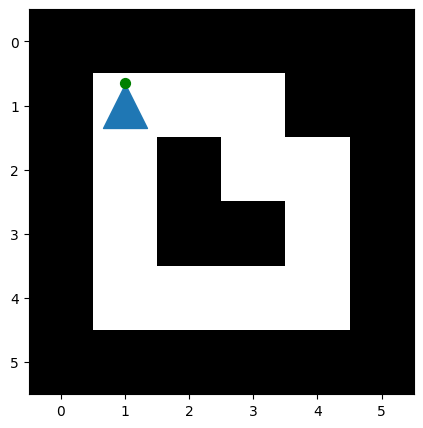

In [4]:
env_test = gridWorld(x= 1, y=1, theta=0, world= np.array([
                [1, 1, 1, 1, 1, 1],
                [1, 0, 0, 0, 1, 1],
                [1, 0, 1, 0, 0, 1],
                [1, 0, 1, 1, 0, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 1, 1, 1, 1, 1],
            ]))
actions, outcomes = [], []
env_test.display_world()

# Tokenizer

In [5]:
list_vocab = ['<pad>']
for act in env_test.get_actions():
    list_vocab.append(act)
for fb in env_test.get_outcomes():
    list_vocab.append(fb)    
tmp = create_dico_numerate_word(list_vocab)
tokenizer = SimpleTokenizerV1(vocab=tmp)

# X and Y

## Chaque séquence est complètement indépendante
### Res :
Spoil : au moins a partir de 500, > 95% d'acc (50 epoch) Attention on comptant les "turn"

In [6]:
data_brut_y=[]
for i in range(750):
    data_brut_y.append(get_data(env_test, tokenizer, n_episodes=50))

data_y = torch.tensor(data_brut_y)
print("data_y.shape", data_y.shape)
data_loader = DataLoader(data_y, batch_size=16, shuffle=True)


data_y.shape torch.Size([750, 100])


## Une grande séquence découper

In [7]:
data_brut = get_data(env_test, tokenizer, n_episodes=100)
print(data_brut)
def decoup_seq(seq:list, size:int, overlap:int=1):
    """
    Decoupe une sequence en sous-sequence de taille size
    """
    return [seq[i:i+size] for i in range(0, len(seq) - size +1, overlap)]

data_decoup = decoup_seq(seq=data_brut, size=30, overlap=10)
print(data_decoup)
data_decoup = torch.tensor(data_decoup)
data_loader_decoup = DataLoader(data_decoup, batch_size=16, shuffle=True)

[5, 7, 3, 8, 1, 8, 5, 7, 6, 7, 1, 8, 2, 8, 2, 8, 4, 8, 5, 7, 2, 8, 4, 7, 3, 8, 5, 7, 5, 7, 6, 7, 3, 8, 5, 8, 1, 7, 5, 8, 2, 8, 1, 8, 3, 8, 5, 8, 5, 8, 1, 7, 5, 8, 4, 7, 1, 7, 5, 8, 5, 8, 6, 8, 4, 7, 5, 8, 2, 8, 3, 8, 4, 7, 3, 8, 1, 8, 3, 8, 1, 7, 6, 8, 3, 8, 6, 7, 6, 7, 1, 8, 4, 8, 4, 8, 6, 7, 2, 8, 2, 8, 2, 8, 4, 7, 1, 7, 6, 8, 6, 8, 3, 8, 6, 7, 2, 8, 5, 8, 5, 8, 4, 7, 1, 7, 2, 8, 3, 8, 3, 8, 1, 8, 6, 7, 3, 8, 6, 8, 5, 8, 4, 7, 1, 7, 3, 8, 5, 7, 2, 8, 6, 8, 3, 8, 3, 8, 2, 8, 3, 8, 6, 8, 3, 8, 6, 7, 2, 8, 4, 7, 5, 8, 5, 8, 4, 7, 3, 8, 5, 7, 6, 7, 6, 7, 6, 7, 6, 7, 3, 8, 3, 8, 2, 8, 3, 8, 1, 8]
[[5, 7, 3, 8, 1, 8, 5, 7, 6, 7, 1, 8, 2, 8, 2, 8, 4, 8, 5, 7, 2, 8, 4, 7, 3, 8, 5, 7, 5, 7], [1, 8, 2, 8, 2, 8, 4, 8, 5, 7, 2, 8, 4, 7, 3, 8, 5, 7, 5, 7, 6, 7, 3, 8, 5, 8, 1, 7, 5, 8], [2, 8, 4, 7, 3, 8, 5, 7, 5, 7, 6, 7, 3, 8, 5, 8, 1, 7, 5, 8, 2, 8, 1, 8, 3, 8, 5, 8, 5, 8], [6, 7, 3, 8, 5, 8, 1, 7, 5, 8, 2, 8, 1, 8, 3, 8, 5, 8, 5, 8, 1, 7, 5, 8, 4, 7, 1, 7, 5, 8], [2, 8, 1, 8, 3, 8, 5, 8, 5, 8,

data_y est alors notre Y. Pour obtenir notre X, nous utiliserons un token Dropen

Notre x est donc data_x. Maintenant nous voulons que notre model arrive à obvenir un représentation de la séquence pour réussir a compléter les 0.

# Multi tasks ?
On peut vouloir un encoder qui apprend a encoder pour deviner les actions, et un encoder qui apprends a deviner les observations.


In [8]:
data_set = SimpleDataSet(data_brut_y)

print("len data_set", data_set.__len__())
print("data_set 1", data_set[0])

tensor([[5, 7, 6,  ..., 8, 4, 7],
        [4, 7, 1,  ..., 7, 5, 8],
        [6, 7, 3,  ..., 7, 2, 8],
        ...,
        [5, 7, 1,  ..., 8, 5, 7],
        [2, 8, 6,  ..., 7, 4, 7],
        [4, 7, 2,  ..., 8, 5, 7]])
len data_set 100
data_set 1 tensor([5, 7, 6, 8, 2, 8, 5, 8, 3, 8, 4, 7, 1, 7, 3, 8, 4, 8, 3, 8, 1, 8, 2, 8,
        4, 7, 2, 8, 1, 8, 1, 7, 2, 8, 4, 7, 3, 8, 1, 7, 3, 8, 2, 8, 6, 8, 4, 7,
        1, 7, 1, 7, 6, 8, 2, 8, 6, 7, 3, 8, 6, 8, 5, 7, 6, 8, 3, 8, 1, 8, 3, 8,
        6, 8, 2, 8, 5, 7, 5, 7, 5, 7, 4, 8, 4, 8, 5, 7, 3, 8, 4, 7, 6, 8, 5, 8,
        6, 8, 4, 7])


In [9]:
def train(model: nn.Module, data_loader_train: DataLoader, nb_epoch: int, optimizer, loss_fn, pourcentTokenDrop:float=0.15):
    td_act = TokenDropEven(pourcentTokenDrop, pad_token=0, num_special=2).to(device)
    td_fb = TokenDropOdd(pourcentTokenDrop, pad_token=0, num_special=2).to(device)

    model.train()
    acc = 0
    total_loss = 0
    list_acc = []
    list_loss = []
    for j in tqdm(range(nb_epoch), desc=f"Training ", unit="epoch"):
        acc_means = [0, 0]
        loss_means = [0, 0]
        
        for i, data in enumerate(data_loader_train):
            data = data.to(device)
            data_mask_act = td_act(data)
            data_mask_fb = td_fb(data)
            bs = data.shape[0]
            # print("batch size ", bs)

            # Initialize the memory buffers
            hidden = torch.zeros(2 * model.num_layers, bs, model.hidden_size, device=device)
            memory = torch.zeros(2 * model.num_layers, bs, model.hidden_size, device=device)
            # print(f'shape hidden and memory {hidden.shape} | {memory.shape}')
            total_loss = 0  # Accumulate loss over both tasks

            for k, tasks in enumerate([data_mask_act, data_mask_fb]):
                # Forward pass
                tasks = tasks.to(device)
                proba, hidden, memory = model(tasks, hidden, memory)
                proba = proba.transpose(1, 2)
                pred = proba.argmax(dim=1)
                pad_mask = (tasks == 0)
                correct = (pred == data) & pad_mask
                acc = correct.sum().item() / pad_mask.sum().item() if pad_mask.sum().item() > 0 else 0.0
                acc_means[k] += acc
                
                loss = loss_fn(proba, data)
                total_loss += loss
                loss_means[k] += loss.item()
                
            # Backward pass and optimization
            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()
        acc_means = [acc / len(data_loader_train) for acc in acc_means]
        loss_means = [loss / len(data_loader_train) for loss in loss_means]
        list_acc.append(acc_means)
        list_loss.append(loss_means)
        tqdm.write(f"Epoch {j + 1}/{nb_epoch}, Loss: {loss_means}, Accuracy: {acc_means}")
        
    return list_acc, list_loss
        
def train_fb(model: nn.Module, data_loader_train: DataLoader, nb_epoch: int, optimizer, loss_fn, pourcentTokenDrop:float=0.15):
    td_fb = TokenDropOdd(pourcentTokenDrop, pad_token=0, num_special=2).to(device)

    model.train()
    list_acc = []
    list_loss = []
    for j in trange(nb_epoch, desc=f"Training ", unit="epoch"):
        acc_means = 0
        loss_means = 0
        
        for i, data in enumerate(data_loader_train):
            data = data.to(device)
            data_mask_fb = td_fb(data).to(device)
            bs = data.shape[0]
            # print("batch size ", bs)

            # Initialize the memory buffers
            hidden = torch.zeros(2 * model.num_layers, bs, model.hidden_size, device=device)
            memory = torch.zeros(2 * model.num_layers, bs, model.hidden_size, device=device)
            # print(f'shape hidden and memory {hidden.shape} | {memory.shape}')
                        
            proba, hidden, memory = model(data_mask_fb, hidden, memory)
            proba = proba.transpose(1, 2)
            pred = proba.argmax(dim=1)
            pad_mask = (data_mask_fb == 0)
 
            correct = (pred == data) & pad_mask
            acc = correct.sum().item() / pad_mask.sum().item() if pad_mask.sum().item() > 0 else 0.0
            acc_means += acc
        
            loss = loss_fn(proba, data) 
            loss_means += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        acc_means /= len(data_loader_train)
        loss_means /= len(data_loader_train)
        list_acc.append(acc_means)
        list_loss.append(loss_means)
        tqdm.write(f"Epoch {j + 1}/{nb_epoch}, Loss: {loss_means}, Accuracy: {acc_means}")
    return list_acc, list_loss

In [10]:
# model_fb_decoup = LSTM_representation(
#     num_emb=len(list_vocab),
#     hidden_size=256,
#     emb_size=256,
#     num_layers=2,
#     dropout=0
# ).to(device)

# optimizer_fb_decoup = optim.Adam(model_fb_decoup.parameters(), lr=0.001)
# loss_fn_fb_decoup = nn.CrossEntropyLoss()

# list_loss, list_acc = train_fb(
#     model=model_fb_decoup,
#     data_loader_train=data_loader_decoup,
#     nb_epoch=100,
#     optimizer=optimizer_fb_decoup,
#     loss_fn=loss_fn_fb_decoup,
#     pourcentTokenDrop=0.1
# )
# # Plot
# plt.figure(figsize=(10, 5))
# plt.plot(list_loss, label='Loss')
# plt.plot(list_acc, label='Accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Value')
# plt.title('Training Loss and Accuracy')
# plt.legend()
# plt.show()

In [11]:
num_layers = 4
hidden_size = 256
model_fb = LSTM_representation(
    num_emb=len(list_vocab),
    hidden_size=hidden_size,
    emb_size=hidden_size,
    num_layers=num_layers,
    dropout=0
).to(device)
# 32 = 95 % | plus de 32 = 95 %
# 16 < 90 %
optimizer_fb = optim.Adam(model_fb.parameters(), lr=0.001)
loss_fn_fb = nn.CrossEntropyLoss()

list_acc, list_loss = train_fb(
    model=model_fb,
    data_loader_train=data_loader,
    nb_epoch=75,
    optimizer=optimizer_fb,
    loss_fn=loss_fn_fb,
    pourcentTokenDrop=0.25
)


Training :   0%|          | 0/75 [00:00<?, ?epoch/s]

Epoch 1/75, Loss: 1.019886481159545, Accuracy: 0.5721415537041312
Epoch 2/75, Loss: 0.05883778615834865, Accuracy: 0.7078127532226981
Epoch 3/75, Loss: 0.05594333871564967, Accuracy: 0.7064657046604323
Epoch 4/75, Loss: 0.052708440163034075, Accuracy: 0.7334297654150528
Epoch 5/75, Loss: 0.0493496558926207, Accuracy: 0.7619321550865948
Epoch 6/75, Loss: 0.045580083306165455, Accuracy: 0.7916781565347092
Epoch 7/75, Loss: 0.04273708576851703, Accuracy: 0.8133479660413206
Epoch 8/75, Loss: 0.03856554726495388, Accuracy: 0.840313496529025
Epoch 9/75, Loss: 0.03567686082517847, Accuracy: 0.8468464304388464
Epoch 10/75, Loss: 0.0334672776863296, Accuracy: 0.8644159890056416
Epoch 11/75, Loss: 0.029568649907695487, Accuracy: 0.8822674862528521
Epoch 12/75, Loss: 0.02951660617551905, Accuracy: 0.8879806029426287
Epoch 13/75, Loss: 0.02474559492808073, Accuracy: 0.9090861949020284
Epoch 14/75, Loss: 0.02253257703194593, Accuracy: 0.9202034042512709
Epoch 15/75, Loss: 0.02125826682102807, Accur

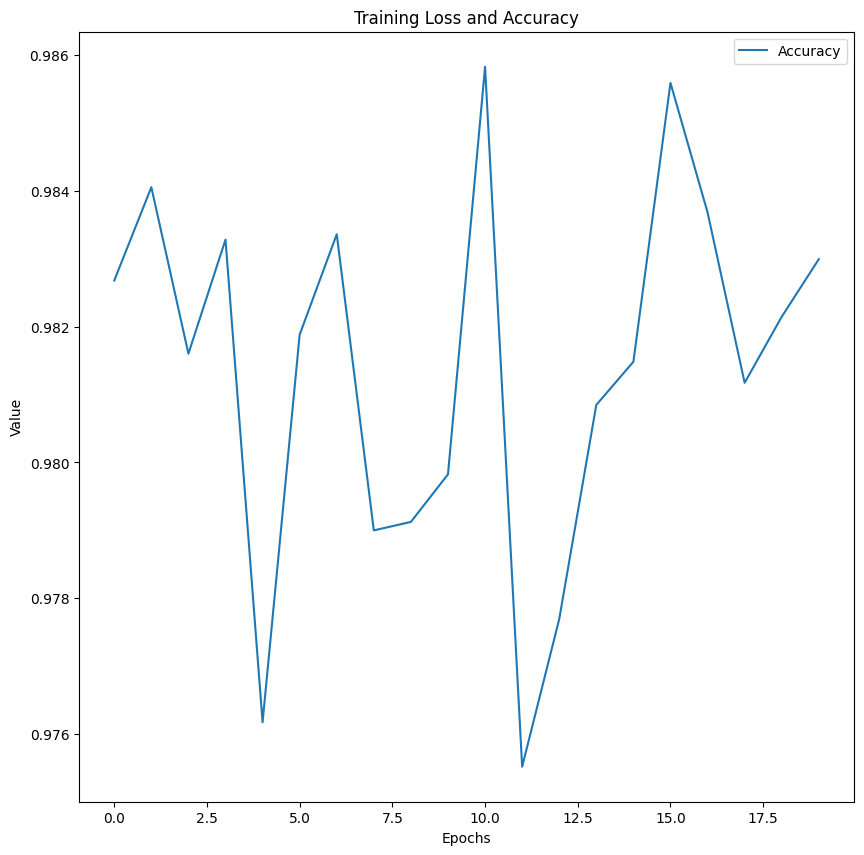

In [12]:
# Plot
plt.figure(figsize=(10, 10))
# plt.plot(list_loss, label='Loss')
plt.plot(list_acc[-20:], label='Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.title('Training Loss and Accuracy')
plt.legend()
plt.show()

In [ ]:
env_test = gridWorld(x= 1, y=1, theta=0, world= np.array([
                [1, 1, 1, 1, 1, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 0, 0, 1, 0, 1],
                [1, 0, 1, 0, 0, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 1, 1, 1, 1, 1],
            ]))

data_test_x = []
data_test_y = []
data_infos = []
for i in range(20000):
    # range_context = np.random.randint(10, 20)
    range_context = 10
    last_act = "turn_left"
    while last_act == "turn_left" or last_act == "turn_right":
        sequence = get_data(env_test, tokenizer, n_episodes=range_context)
        last_act = tokenizer.decode(sequence[-2])
            
    data_test_x.append(sequence[:-1] + [0])    
    data_test_y.append(sequence[-1])
    
    data_infos.append({
        "sequence": sequence,
        "coo": env_test.get_coo(),
        "theta": env_test.get_theta(),
        "last_act": last_act,
        "last_feedback": tokenizer.decode(sequence[-1]),
        "info_in_sequence": bool(info_in_seq(tokenizer.decode(data_test_x[-1]), 6))
    })
    around = ''
    for feel in ["feel_front", "feel_left", "feel_right"]:
        state = env_test.outcome(feel)
        data_infos[-1][feel] = state
        around += f"{state}|"
    
# print("data_test_x", data_test_x)
# print("data_test_y", data_test_y)

# count 9 and 8 in data_test_y
count_7 = 0
count_8 = 0

for i in data_test_y:
    if i == 8:
        count_8 += 1
    elif i == 7:
        count_7 += 1
print(f"count_8 {tokenizer.decode(8)}", count_8)
print(f"count_7 {tokenizer.decode(7)}", count_7)

print("data_infos", data_infos[0])
print("x ", data_test_x[0])
print("y ", data_test_y[0])

The robot is in : 0  x: 1 y: 1
World : [[1 1 1 1 1 1]
 [1 0 0 0 0 1]
 [1 0 0 1 0 1]
 [1 0 1 0 0 1]
 [1 0 0 0 0 1]
 [1 1 1 1 1 1]]
count_8 empty 10385
count_7 wall 9615
data_infos {'sequence': [5, 7, 6, 8, 1, 8, 6, 7, 2, 8, 5, 8, 4, 7, 3, 8, 4, 8, 4, 8, 2, 8, 6, 8, 2, 8, 2, 8, 1, 7, 3, 8, 3, 8, 4, 7, 4, 7, 1, 7, 3, 8, 5, 7, 6, 7, 1, 8, 5, 7, 3, 8, 1, 8, 5, 7, 5, 7, 4, 8, 5, 7, 5, 7, 6, 7, 5, 7, 2, 8, 4, 7, 2, 8, 5, 7, 1, 8, 2, 8, 1, 8, 4, 8, 1, 8, 2, 8, 6, 8, 4, 8, 2, 8, 3, 8, 4, 8, 5, 8], 'coo': (2, 1), 'theta': 2, 'last_act': 'feel_left', 'last_feedback': 'empty', 'info_in_sequence': True, 'feel_front': 'empty', 'feel_left': 'empty', 'feel_right': 'empty'}
x  [5, 7, 6, 8, 1, 8, 6, 7, 2, 8, 5, 8, 4, 7, 3, 8, 4, 8, 4, 8, 2, 8, 6, 8, 2, 8, 2, 8, 1, 7, 3, 8, 3, 8, 4, 7, 4, 7, 1, 7, 3, 8, 5, 7, 6, 7, 1, 8, 5, 7, 3, 8, 1, 8, 5, 7, 5, 7, 4, 8, 5, 7, 5, 7, 6, 7, 5, 7, 2, 8, 4, 7, 2, 8, 5, 7, 1, 8, 2, 8, 1, 8, 4, 8, 1, 8, 2, 8, 6, 8, 4, 8, 2, 8, 3, 8, 4, 8, 5, 0]
y  8


In [14]:
length = max(len(xi) for xi in data_test_x)
data_test_x_tensor = torch.zeros((len(data_test_x), length), dtype=torch.long)
for i, xi in enumerate(data_test_x):
    data_test_x_tensor[i, :len(xi)] = torch.tensor(xi, dtype=torch.long)
data_test_y_tensor = torch.tensor(data_test_y, dtype=torch.long)

class CustomDataset(Dataset):
    def __init__(self, data:torch.Tensor, targets:torch.Tensor, data_infos):
        self.data = data
        self.targets = targets
        self.infos = data_infos

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        target = self.targets[idx]
        info = self.infos[idx]
        return sample, target, info

data_loader_test = DataLoader(CustomDataset(data_test_x_tensor, data_test_y_tensor, data_infos), batch_size=1, shuffle=False)

for i, (data_x, data_y, info) in enumerate(data_loader_test):
    print(data_x)
    print(data_y)
    for key, value in info.items():
        print(f"{key}: {value}")
    break

tensor([[5, 7, 6, 8, 1, 8, 6, 7, 2, 8, 5, 8, 4, 7, 3, 8, 4, 8, 4, 8, 2, 8, 6, 8,
         2, 8, 2, 8, 1, 7, 3, 8, 3, 8, 4, 7, 4, 7, 1, 7, 3, 8, 5, 7, 6, 7, 1, 8,
         5, 7, 3, 8, 1, 8, 5, 7, 5, 7, 4, 8, 5, 7, 5, 7, 6, 7, 5, 7, 2, 8, 4, 7,
         2, 8, 5, 7, 1, 8, 2, 8, 1, 8, 4, 8, 1, 8, 2, 8, 6, 8, 4, 8, 2, 8, 3, 8,
         4, 8, 5, 0]])
tensor([8])
sequence: [tensor([5]), tensor([7]), tensor([6]), tensor([8]), tensor([1]), tensor([8]), tensor([6]), tensor([7]), tensor([2]), tensor([8]), tensor([5]), tensor([8]), tensor([4]), tensor([7]), tensor([3]), tensor([8]), tensor([4]), tensor([8]), tensor([4]), tensor([8]), tensor([2]), tensor([8]), tensor([6]), tensor([8]), tensor([2]), tensor([8]), tensor([2]), tensor([8]), tensor([1]), tensor([7]), tensor([3]), tensor([8]), tensor([3]), tensor([8]), tensor([4]), tensor([7]), tensor([4]), tensor([7]), tensor([1]), tensor([7]), tensor([3]), tensor([8]), tensor([5]), tensor([7]), tensor([6]), tensor([7]), tensor([1]), tensor([8]), tensor

In [15]:
model_fb.eval()
acc = 0

data_frame_seq = pd.DataFrame({
    "seq": [""] * len(data_loader_test),
    "seq_dec": [""] * len(data_loader_test),
    "prediction": [""] * len(data_loader_test),
    "prediction_dec": [""] * len(data_loader_test),
    "reality": [""] * len(data_loader_test),
    "reality_dec": [""] * len(data_loader_test),
    "probability": [""] * len(data_loader_test),
    "good_prediction": [False] * len(data_loader_test),
    "info_in_seq": [False] * len(data_loader_test),
    "info_feel_left": [False] * len(data_loader_test),
    "info_feel_front": [False] * len(data_loader_test),
    "info_feel_right": [False] * len(data_loader_test),
    "coo_xy": [""] * len(data_loader_test),
    "theta": [-1] * len(data_loader_test),
    "state_left": [""] * len(data_loader_test),
    "state_front": [""] * len(data_loader_test),
    "state_right": [""] * len(data_loader_test),
    
})

# data_frame_seq = data_frame_seq.astype({
#     "seq": "object",
#     "prediction": "U20",
#     "reality": "object",
#     "probability": "object",
#     "good_prediction": "bool",
#     "info_in_seq": "bool",
#     "info_feel_left": "bool",
#     "info_feel_front": "bool",
#     "info_feel_right": "bool",
#     "coo_xy": "object",
#     "theta": "int64"
# })

with torch.no_grad():
    for i, (input, target, info) in tqdm(enumerate(data_loader_test)):
        input = input.to(device)
        target = target.to(device)
        h = torch.zeros(model_fb.num_layers * 2, 1, model_fb.hidden_size).to(device)
        cell = torch.zeros(model_fb.num_layers * 2, 1, model_fb.hidden_size).to(device)
        output, h, cell = model_fb(input, h, cell)
        
        arrays, x, y, theta = process_sequence(tokenizer.decode(input.tolist()[0]), 6, None)
        good_seq = info_in_memory(arrays)
        feel_left, feel_front, feel_right = feel_info_end_sequence(tokenizer.decode(input.tolist()[0]), 6, (arrays, x, y, theta))
        
        proba = F.softmax(output, dim=-1)
        output = output.transpose(1, 2)
        pred = output.argmax(dim=1)
        acc += (pred[-1][-1] == target).item()
        state_left = info["feel_left"][0]
        state_front = info["feel_front"][0]
        state_right = info["feel_right"][0]
        coo = (info["coo"][0].item(), info["coo"][1].item())
        theta = info["theta"][0].item()

        data_frame_seq.loc[i] = [
            str(input.tolist()[0]),
            str(tokenizer.decode(input.tolist()[0])),
            str(pred.tolist()[0][-1]),
            str(tokenizer.decode(pred.tolist()[0][-1])),
            target.tolist()[0],
            tokenizer.decode(target.tolist()[0]),
            str(proba.tolist()[-1][-1][-2:]),
            (pred[-1][-1] == target).item(),
            good_seq,
            feel_left,
            feel_front,
            feel_right,
            str(coo),
            theta,
            state_left,
            state_front,
            state_right
        ]
print(f"Accuracy: {acc / 20000}")

0it [00:00, ?it/s]

Accuracy: 0.8818


In [16]:
# end

In [17]:
model_fb.eval()
prompt = tokenizer.encode(
['feel_front', 'wall', 'turn_right', 'empty', 'turn_right', 'empty', 'feel_front', 'empty', 'turn_right', 'empty', 'feel_front', 'wall', 'turn_right', 'empty', 'turn_right', 'empty', 'turn_right', 'empty', 'feel_front', '<pad>']
)

hidden = torch.zeros(2 * model_fb.num_layers, 1, model_fb.hidden_size).to(device)
memory = torch.zeros(2 * model_fb.num_layers, 1, model_fb.hidden_size).to(device)

prompt_tensor = torch.tensor(prompt).to(device)
prompt_tensor = prompt_tensor.unsqueeze(0)
_proba, hidden, memory = model_fb(prompt_tensor, hidden, memory)
proba = _proba.transpose(1, 2)
pred = proba.argmax(dim=1)

print(tokenizer.decode(prompt_tensor[0].tolist()))
print(tokenizer.decode(pred[0].tolist()))
print("proba for last token", torch.round(F.softmax(_proba[0, -1, :], dim=0) * 1000) / 1000)
prompt = tokenizer.encode(
    ['turn_right', 'empty', 'turn_left', 'empty', 'feel_front', 'wall', 'feel_front', 'wall', 
     'forward', 'wall', 'feel_right', 'empty', 'feel_right', 'empty', 'feel_front', 'wall', 
     'feel_left', 'wall', 'feel_front', '<pad>'])


hidden = torch.zeros(2 * model_fb.num_layers, 1, model_fb.hidden_size).to(device)
memory = torch.zeros(2 * model_fb.num_layers, 1, model_fb.hidden_size).to(device)

prompt_tensor = torch.tensor(prompt).to(device)
prompt_tensor = prompt_tensor.unsqueeze(0)
_proba, hidden, memory = model_fb(prompt_tensor, hidden, memory)
proba = _proba.transpose(1, 2)
pred = proba.argmax(dim=1)

print(tokenizer.decode(pred[0].tolist()))
print("proba for last token", torch.round(F.softmax(_proba[0, -1, :], dim=0) * 1000) / 1000)

prompt = tokenizer.encode(
    ['turn_right', 'empty', 'turn_left', 'empty', 'feel_front', 'wall', 'feel_front', 'wall', 
     'forward', 'wall', 'feel_right', 'empty', 'feel_right', 'empty', 'feel_front', 'wall', 
     'feel_left', 'wall', 'feel_left', '<pad>'])

hidden = torch.zeros(2 * model_fb.num_layers, 1, model_fb.hidden_size).to(device)
memory = torch.zeros(2 * model_fb.num_layers, 1, model_fb.hidden_size).to(device)

prompt_tensor = torch.tensor(prompt).to(device)
prompt_tensor = prompt_tensor.unsqueeze(0)
_proba, hidden, memory = model_fb(prompt_tensor, hidden, memory)
proba = _proba.transpose(1, 2)
pred = proba.argmax(dim=1)

print(tokenizer.decode(pred[0].tolist()))
print("proba for last token", torch.round(F.softmax(_proba[0, -1, :], dim=0) * 1000) / 1000)



['feel_front', 'wall', 'turn_right', 'empty', 'turn_right', 'empty', 'feel_front', 'empty', 'turn_right', 'empty', 'feel_front', 'wall', 'turn_right', 'empty', 'turn_right', 'empty', 'turn_right', 'empty', 'feel_front', '<pad>']
['feel_front', 'wall', 'turn_right', 'empty', 'turn_right', 'empty', 'feel_front', 'empty', 'turn_right', 'empty', 'feel_front', 'wall', 'turn_right', 'empty', 'turn_right', 'empty', 'turn_right', 'empty', 'feel_front', 'empty']
proba for last token tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0040, 0.9960],
       device='cuda:0', grad_fn=<DivBackward0>)
['turn_right', 'empty', 'turn_left', 'empty', 'feel_front', 'wall', 'feel_front', 'wall', 'forward', 'wall', 'feel_right', 'empty', 'feel_right', 'empty', 'feel_front', 'wall', 'feel_left', 'wall', 'feel_front', 'wall']
proba for last token tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.9900, 0.0090],
       device='cuda:0', grad_fn=<DivBackward0>)
['turn_right', 'empty'

In [18]:
for key, value in data_infos[56].items():
    print(f"{key}: {value}")


sequence: [1, 7, 1, 7, 2, 8, 6, 7, 6, 7, 3, 8, 3, 8, 5, 7, 6, 8, 4, 8, 4, 8, 1, 8, 1, 8, 1, 8, 5, 7, 4, 7, 5, 7, 1, 7, 2, 8, 5, 8, 4, 7, 4, 7, 4, 7, 5, 8, 3, 8, 4, 7, 2, 8, 3, 8, 4, 7, 1, 7, 3, 8, 1, 8, 5, 7, 4, 8, 6, 8, 4, 8, 4, 8, 5, 7, 1, 8, 3, 8, 6, 8, 2, 8, 4, 8, 1, 8, 2, 8, 1, 7, 2, 8, 3, 8, 2, 8, 4, 8]
coo: (4, 1)
theta: 3
last_act: feel_front
last_feedback: empty
info_in_sequence: True
feel_front: empty
feel_left: empty
feel_right: wall


In [19]:
# keep only row with good_prediction = True
data_frame_seq_success = data_frame_seq.loc[data_frame_seq["good_prediction"]]

# Résultat

0.96 % d'accuracy  

data test est constituer de 82% sequence dont l'information/feedback demandé a été vue  

Sur la partie où l’information n'est pas dans la séquence, l'accuracy tombe à 83%  

Sur la partie où l’information est dans la séquence, l'accuracy monte à 99%

## Not same environment
Quand il n'y a pas le même environment (autre grille) entre le train et le teste, 
acc = 83%
  
Si nous prenons que les seq avec infos alors on passe à 97% 

## Big context
0.97 % 
92% on une séquence avec une infos
sinon même stats

# Embeding

In [20]:
model_fb.eval()
hidden_in = torch.zeros(model_fb.num_layers * 2, 1, model_fb.hidden_size).to(device)
mem_in = torch.zeros(model_fb.num_layers * 2, 1, model_fb.hidden_size).to(device)
print("hidden_in", hidden_in.shape)
print("mem_in", mem_in.shape)
all_hidden = []
all_mem = []
all_output_1 = []
all_output_2 = []
all_output_3 = []
all_embedding = []

data_infos_success = data_frame_seq.loc[
    (data_frame_seq["info_in_seq"])
]
print("data_infos_success", len(data_infos_success))

# data_infos_sucess = [d for d in data_infos if all(d["feel_left", "feel_front", "feel_right"])]
for sequence in data_infos_success["seq"]:
    sequence = eval(sequence)
    input_seq = torch.tensor(sequence).to(device)
    all_embedding.append(model_fb.embedding(input_seq))
    # print("input_seq", input_seq.shape)
    output, (hidden_out, mem_out) = model_fb.lstm(all_embedding[-1])
    all_hidden.append(hidden_out[-1])
    all_mem.append(mem_out[-1])
    all_output_1.append(output[-1])
    all_output_2.append(output[-2])
    all_output_3.append(output[-3])


# print("shape output", all_output_1[0].shape)

hidden_in torch.Size([8, 1, 256])
mem_in torch.Size([8, 1, 256])
data_infos_success 17065


OutOfMemoryError: CUDA out of memory. Tried to allocate 88.00 MiB. GPU 0 has a total capacity of 5.67 GiB of which 89.12 MiB is free. Including non-PyTorch memory, this process has 5.56 GiB memory in use. Of the allocated memory 5.28 GiB is allocated by PyTorch, and 145.45 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

hidden_in torch.Size([8, 1, 256])
mem_in torch.Size([8, 1, 256])
data_infos_success 13234
input_seq torch.Size([20])
output torch.Size([20, 512])
hidden_out torch.Size([8, 256])
mem_out torch.Size([8, 256])

In [ ]:
print(tokenizer.encode(["feel_front", "feel_left", "feel_right"]))

In [ ]:
import seaborn as sns

In [ ]:
# tsne = TSNE(n_components=2, random_state=42, perplexity=5, max_iter=300)
# all_hidden_stack = torch.stack(all_hidden)
# all_mem_stack = torch.stack(all_mem)
# all_hidden_stack = all_hidden_stack.detach().cpu().numpy()
# all_mem_stack = all_mem_stack.detach().cpu().numpy()
# all_hidden_emb = tsne.fit_transform(all_hidden_stack)
# all_mem_emb = tsne.fit_transform(all_mem_stack)

# coo_info = data_infos_success["coo_xy"].tolist()

# unique_coo = np.unique(coo_info)
# color_map = plt.get_cmap('viridis', len(unique_coo))
# coo_colors = [color_map(unique_coo.tolist().index(str(coo))) for coo in coo_info]

# theta_info = data_infos_success["theta"].tolist()

# unique_theta = np.unique(theta_info)
# # Attribuer une former pour chaque valeur unique de theta
# markers_list = ['o', 's', 'D', 'v', '^', '<', '>', 'P', 'X', '*']
# markers_map = {theta: markers_list[i % len(markers_list)] for i, theta in enumerate(unique_theta)}
# theta_markers = [markers_map[theta] for theta in theta_info]


# plt.figure(figsize=(12, 6))

# # Plot pour all_hidden_emb
# plt.subplot(1, 2, 1)
# plt.scatter(all_hidden_emb[:, 0], all_hidden_emb[:, 1], c=coo_colors, cmap='rocket', alpha=0.6)
# plt.title('t-SNE visualization of hidden states')
# plt.xlabel('t-SNE component 1')
# plt.ylabel('t-SNE component 2')

# # Plot pour all_mem_emb
# plt.subplot(1, 2, 2)
# plt.scatter(all_mem_emb[:, 0], all_mem_emb[:, 1], c=coo_colors, cmap='rocket', alpha=0.6)
# plt.title('t-SNE visualization of memory states')
# plt.xlabel('t-SNE component 1')
# plt.ylabel('t-SNE component 2')

# # Ajouter une légende pour les couleurs
# for coo, color in zip(unique_coo, color_map(np.arange(len(unique_coo)))):
#     plt.scatter([], [], c=[color], label=f'coo {coo}')
# plt.legend(title='coo values')

# plt.tight_layout()
# plt.show()
# plt.close()

# tsne = TSNE(n_components=2, random_state=42, perplexity=2, max_iter=300)

# all_output_stack = torch.stack(all_output_1)
# all_output_stack = all_output_stack.detach().cpu().numpy()
# print("all_output_stack", all_output_stack.shape)
# all_output_emb = tsne.fit_transform(all_output_stack)
# print("all_output_emb", all_output_emb.shape)
# plt.figure(figsize=(12, 6))
# for i in range(len(all_output_emb)):
#     plt.scatter(all_output_emb[i, 0], all_output_emb[i, 1], c=[coo_colors[i]], marker=theta_markers[i], alpha=0.6)
# plt.title('t-SNE visualization of output states')
# plt.xlabel('t-SNE component 1')
# plt.ylabel('t-SNE component 2')
# # Ajouter une légende pour les couleurs
# for coo, color in zip(unique_coo, color_map(np.arange(len(unique_coo)))):
#     plt.scatter([], [], c=[color], label=f'coo {coo}')
# plt.legend(title='coo values')
# plt.tight_layout()
# plt.show()
# plt.close()

# tsne = TSNE(n_components=2, random_state=42, perplexity=2, n_iter=300)

# all_output_stack = torch.stack(all_output_2)
# all_output_stack = all_output_stack.detach().cpu().numpy()
# print("all_output_stack", all_output_stack.shape)
# all_output_emb = tsne.fit_transform(all_output_stack)
# print("all_output_emb", all_output_emb.shape)
# plt.figure(figsize=(12, 6))
# plt.scatter(all_output_emb[:, 0], all_output_emb[:, 1], c=coo_colors, cmap='rocket', alpha=0.6)
# plt.title('t-SNE visualization of output states')
# plt.xlabel('t-SNE component 1')
# plt.ylabel('t-SNE component 2')
# # Ajouter une légende pour les couleurs
# for coo, color in zip(unique_coo, color_map(np.arange(len(unique_coo)))):
#     plt.scatter([], [], c=[color], label=f'coo {coo}')
# plt.legend(title='coo values')
# plt.tight_layout()
# plt.show()
# plt.close()

In [ ]:
import plotly.graph_objects as go
tsne = TSNE(n_components=3, random_state=42, perplexity=5, max_iter=300)

# Stack embeddings and convert to numpy array
all_embedding_stack = torch.stack(all_embedding)
all_embedding_stack = all_embedding_stack.detach().cpu().numpy()
print("shape all_embedding_stack", all_embedding_stack.shape)
all_embedding_stack = all_embedding_stack.reshape(all_embedding_stack.shape[0], -1)
print("reshape in ", all_embedding_stack.shape)

# Apply t-SNE to individual embeddings
all_embedding_emb = tsne.fit_transform(all_embedding_stack)

# Get all tokens
all_token = env_test.get_actions() + env_test.get_outcomes() + ['<pad>']
unique_tokens = all_token

# Create color map
n_colors = len(unique_tokens)
color_map = plt.get_cmap('tab20', n_colors)
token_colors = [color_map(i) for i in range(n_colors)]
token_color_map = {tok: f'rgb({int(r*255)}, {int(g*255)}, {int(b*255)})' for tok, (r, g, b, _) in zip(unique_tokens, token_colors)}

# Define token markers
token_marker_map = {
    '<pad>': 'cross',
    'empty': 'square-open',
    'wall': 'square',
    'forward': 'diamond',
    'feel_front': 'diamond',
    'feel_left': 'diamond',
    'feel_right': 'diamond',
    'turn_left': 'circle',
    'turn_right': 'circle',
}

# Create 3D scatter plot
fig = go.Figure()
for tok in unique_tokens:
    idxs = [i for i, t in enumerate(all_token) if t == tok]
    fig.add_trace(go.Scatter3d(
        x=all_embedding_emb[idxs, 0],
        y=all_embedding_emb[idxs, 1],
        z=all_embedding_emb[idxs, 2],
        mode='markers',
        marker=dict(
            size=5,
            color=token_color_map[tok],
            line=dict(width=1),
            symbol=token_marker_map[tok],
            opacity=1
        ),
        name=tok
    ))

fig.update_layout(
    title='3D t-SNE visualization of embeddings (token markers)',
    scene=dict(
        xaxis_title='t-SNE component 1',
        yaxis_title='t-SNE component 2',
        zaxis_title='t-SNE component 3'
    )
)

fig.show()

circle', 'circle-open', 'cross', 'diamond',
            'diamond-open', 'square', 'square-open', 'x']

In [ ]:
print(unique_tokens)

In [ ]:
RANDOM_STATE = 4
tsne = TSNE(n_components=2, random_state=RANDOM_STATE, perplexity=5, max_iter=300)
all_hidden_stack = torch.stack(all_hidden)
all_mem_stack = torch.stack(all_mem)
print("all_hidden", all_hidden_stack.shape)
print("all_mem", all_mem_stack.shape)
all_hidden_stack = all_hidden_stack.detach().cpu().numpy()
all_mem_stack = all_mem_stack.detach().cpu().numpy()
print("all_hidden", all_hidden_stack.shape)
print("all_mem", all_mem_stack.shape)
all_hidden_emb = tsne.fit_transform(all_hidden_stack)
all_mem_emb = tsne.fit_transform(all_mem_stack)
print("all_hidden_emb", all_hidden_emb.shape)
print("all_mem_emb", all_mem_emb.shape)

tsne = TSNE(n_components=2, random_state=RANDOM_STATE, perplexity=2, max_iter=300)

all_output_stack_1 = torch.stack(all_output_1)
all_output_stack_1 = all_output_stack_1.detach().cpu().numpy()
print("all_output_stack", all_output_stack_1.shape)
all_output_emb_1 = tsne.fit_transform(all_output_stack_1)
print("all_output_emb", all_output_emb_1.shape)

tsne = TSNE(n_components=2, random_state=RANDOM_STATE, perplexity=2, max_iter=300)

all_output_stack_2 = torch.stack(all_output_2)
all_output_stack_2 = all_output_stack_2.detach().cpu().numpy()
print("all_output_stack", all_output_stack_2.shape)
all_output_emb_2 = tsne.fit_transform(all_output_stack_2)
print("all_output_emb", all_output_stack_2.shape)


all_output_stack_3 = torch.stack(all_output_3)
all_output_stack_3 = all_output_stack_3.detach().cpu().numpy()
print("all_output_stack", all_output_stack_3.shape)
all_output_emb_3 = tsne.fit_transform(all_output_stack_3)

tsne_3D = TSNE(n_components=3, random_state=RANDOM_STATE, perplexity=5, max_iter=300)
all_output_emb_3D = tsne_3D.fit_transform(all_output_stack_1)

In [ ]:
# feel_info = [str(info[0][0:2]) + '|' + str(info[1][0:2]) + '|' + str(info[2][0:2]) for info in zip(data_infos_success["state_left"], data_infos_success["state_front"], data_infos_success["state_right"])]
feel_info = [str(eval(info[0])[-2]) + '|' + str(info[1][0:2]) for info in zip(data_infos_success["seq_dec"], data_infos_success["reality_dec"], data_infos_success["state_right"])]

print("feel_info", feel_info)
unique_feel = np.unique(feel_info)
print("unique_feel", unique_feel)
color_map = plt.get_cmap('viridis', len(unique_feel))
feel_colors = [color_map(unique_feel.tolist().index(str(feel))) for feel in feel_info]

plt.figure(figsize=(12, 6))
# plt.scatter(all_output_emb[:, 0], all_output_emb[:, 1], c=feel_colors, cmap='viridis', alpha=0.6)
# for i in range(len(all_output_emb_1)):
plt.scatter(all_output_emb_1[:, 0], all_output_emb_1[:, 1], c=feel_colors, alpha=0.6)
plt.title('t-SNE result of LSTM blocks at the last element of the sequence, according to last action and prediction')
plt.xlabel('t-SNE component 1')
plt.ylabel('t-SNE component 2')
# Ajouter une légende pour les couleurs
for feel, color in zip(unique_feel, color_map(np.arange(len(unique_feel)))):
    plt.scatter([], [], c=[color], label=f'{feel}')
plt.legend(title='last action and prediction (act|out)')
plt.tight_layout()
plt.show()

outcome_info = [info for info in data_infos_success["reality_dec"]]
unique_out = ['empty', 'wall']
color_map_out = plt.get_cmap('viridis', len(unique_out))
out_colors = [color_map_out(unique_out.index(str(out))) for out in outcome_info]

print("all_output_emb", all_output_emb_1.shape)
plt.figure(figsize=(12, 6))
plt.scatter(all_output_emb_1[:, 0], all_output_emb_1[:, 1], c=out_colors, alpha=0.6)
plt.title('t-SNE result of LSTM blocks at the last element of the sequence, according to reality outcome')
plt.xlabel('t-SNE component 1')
plt.ylabel('t-SNE component 2')
# Ajouter une légende pour les couleurs
for feel, color in zip(unique_out, color_map_out(np.arange(len(unique_out)))):
    plt.scatter([], [], c=[color], label=f'{feel}')
plt.legend(title='outcomes values')
plt.tight_layout()
plt.show()

action_info = [str(eval(info)[-2]) for info in data_infos_success["seq_dec"]]
unique_act = ['forward', 'feel_front', 'feel_left', 'feel_right']
color_map_act = plt.get_cmap('viridis', len(unique_act))
act_colors = [color_map_act(unique_act.index(str(act))) for act in action_info]

plt.figure(figsize=(12, 6))
plt.scatter(all_output_emb_1[:, 0], all_output_emb_1[:, 1], c=act_colors, alpha=0.6)
plt.title('t-SNE result of LSTM blocks at the last element of the sequence, according to last action')
plt.xlabel('t-SNE component 1')
plt.ylabel('t-SNE component 2')
# Ajouter une légende pour les couleurs
for feel, color in zip(unique_act, color_map_act(np.arange(len(unique_act)))):
    plt.scatter([], [], c=[color], label=f'{feel}')
plt.legend(title='Actions :')
plt.tight_layout()
plt.show()

# ================================================= ICI =================================================

plt.figure(figsize=(12, 6))
# plt.scatter(all_output_emb[:, 0], all_output_emb[:, 1], c=feel_colors, cmap='viridis', alpha=0.6)
# for i in range(len(all_output_emb_2)):
plt.scatter(all_output_emb_2[:, 0], all_output_emb_2[:, 1], c=feel_colors, alpha=0.6)
plt.title('t-SNE result of LSTM blocks at the last last action of the sequence, according to last action and prediction')
plt.xlabel('t-SNE component 1')
plt.ylabel('t-SNE component 2')
# Ajouter une légende pour les couleurs
for feel, color in zip(unique_feel, color_map(np.arange(len(unique_feel)))):
    plt.scatter([], [], c=[color], label=f'{feel}')
plt.legend(title='last action and prediction (act|out)')
plt.tight_layout()
plt.show()

outcome_info = [info for info in data_infos_success["reality_dec"]]
unique_out = ['empty', 'wall']
color_map_out = plt.get_cmap('viridis', len(unique_out))
out_colors = [color_map_out(unique_out.index(str(out))) for out in outcome_info]

print("all_output_emb", all_output_emb_2.shape)
plt.figure(figsize=(12, 6))
plt.scatter(all_output_emb_2[:, 0], all_output_emb_2[:, 1], c=out_colors, alpha=0.6)
plt.title('t-SNE result of LSTM blocks at the last last action of the sequence, according to reality outcome')
plt.xlabel('t-SNE component 1')
plt.ylabel('t-SNE component 2')
# Ajouter une légende pour les couleurs
for feel, color in zip(unique_out, color_map_out(np.arange(len(unique_out)))):
    plt.scatter([], [], c=[color], label=f'{feel}')
plt.legend(title='outcomes values')
plt.tight_layout()
plt.show()

action_info = [str(eval(info)[-2]) for info in data_infos_success["seq_dec"]]
unique_act = ['forward', 'feel_front', 'feel_left', 'feel_right']
color_map_act = plt.get_cmap('viridis', len(unique_act))
act_colors = [color_map_act(unique_act.index(str(act))) for act in action_info]

plt.figure(figsize=(12, 6))
plt.scatter(all_output_emb_2[:, 0], all_output_emb_2[:, 1], c=act_colors, alpha=0.6)
plt.title('t-SNE result of LSTM blocks at the last last action of the sequence, according to last action')
plt.xlabel('t-SNE component 1')
plt.ylabel('t-SNE component 2')
# Ajouter une légende pour les couleurs
for feel, color in zip(unique_act, color_map_act(np.arange(len(unique_act)))):
    plt.scatter([], [], c=[color], label=f'{feel}')
plt.legend(title='Actions :')
plt.tight_layout()
plt.show()

# ================================================= ICI =================================================


# plt.figure(figsize=(12, 6))
# plt.scatter(all_output_emb_2[:, 0], all_output_emb_2[:, 1], c=feel_colors, cmap='viridis', alpha=0.6)
# plt.title('t-SNE visualization of feels states')
# plt.xlabel('t-SNE component 1')
# plt.ylabel('t-SNE component 2')
# # Ajouter une légende pour les couleurs
# for feel, color in zip(unique_feel, color_map(np.arange(len(unique_feel)))):
#     plt.scatter([], [], c=[color], label=f'{feel}')
# plt.legend(title='feels values (Left Front Right)')
# plt.tight_layout()
# plt.show()

# outcome_info = [str(eval(info)[-3]) for info in data_infos_success["seq_dec"]]

# unique_out = ['empty', 'wall']
# out_colors = [color_map_out(unique_out.index(str(out))) for out in outcome_info]

# print("all_output_emb", all_output_emb_3.shape)
# plt.figure(figsize=(12, 6))
# plt.scatter(all_output_emb_3[:, 0], all_output_emb_3[:, 1], c=out_colors, cmap='viridis', alpha=0.6)
# plt.title('t-SNE visualization of output states')
# plt.xlabel('t-SNE component 1')
# plt.ylabel('t-SNE component 2')
# # Ajouter une légende pour les couleurs
# for feel, color in zip(unique_out, color_map_out(np.arange(len(unique_out)))):
#     plt.scatter([], [], c=[color], label=f'{feel}')
# plt.legend(title='outcomes values')
# plt.tight_layout()
# plt.show()


feel_info = [str(eval(info[0])[-2]) + '|' + str(info[1][0:2]) for info in zip(data_infos_success["seq_dec"], data_infos_success["reality_dec"], data_infos_success["state_right"])]

print("feel_info", feel_info)
unique_feel = np.unique(feel_info)
print("unique_feel", unique_feel)
color_map = plt.get_cmap('viridis', len(unique_feel))
feel_colors = [color_map(unique_feel.tolist().index(str(feel))) for feel in feel_info]

plt.figure(figsize=(12, 6))
# plt.scatter(all_output_emb[:, 0], all_output_emb[:, 1], c=feel_colors, cmap='viridis', alpha=0.6)
# for i in range(len(all_output_emb_1)):
plt.scatter(all_hidden_emb[:, 0], all_hidden_emb[:, 1], c=feel_colors, alpha=0.6)
plt.title('t-SNE result of LSTM block at last action by last action and prediction')
plt.xlabel('t-SNE component 1')
plt.ylabel('t-SNE component 2')
# Ajouter une légende pour les couleurs
for feel, color in zip(unique_feel, color_map(np.arange(len(unique_feel)))):
    plt.scatter([], [], c=[color], label=f'{feel}')
plt.legend(title='last action and prediction (act|out)')
plt.tight_layout()
plt.show()

outcome_info = [info for info in data_infos_success["reality_dec"]]
unique_out = ['empty', 'wall']
color_map_out = plt.get_cmap('viridis', len(unique_out))
out_colors = [color_map_out(unique_out.index(str(out))) for out in outcome_info]

plt.figure(figsize=(12, 6))
plt.scatter(all_hidden_emb[:, 0], all_hidden_emb[:, 1], c=out_colors, alpha=0.6)
plt.title('t-SNE result of LSTM block at last action by last result')
plt.xlabel('t-SNE component 1')
plt.ylabel('t-SNE component 2')
# Ajouter une légende pour les couleurs
for feel, color in zip(unique_out, color_map_out(np.arange(len(unique_out)))):
    plt.scatter([], [], c=[color], label=f'{feel}')
plt.legend(title='outcomes values')
plt.tight_layout()
plt.show()

action_info = [str(eval(info)[-2]) for info in data_infos_success["seq_dec"]]
unique_act = ['forward', 'feel_front', 'feel_left', 'feel_right']
color_map_act = plt.get_cmap('viridis', len(unique_act))
act_colors = [color_map_act(unique_act.index(str(act))) for act in action_info]

plt.figure(figsize=(12, 6))
plt.scatter(all_hidden_emb[:, 0], all_hidden_emb[:, 1], c=act_colors, alpha=0.6)
plt.title('t-SNE result of LSTM block at last action by last action')
plt.xlabel('t-SNE component 1')
plt.ylabel('t-SNE component 2')
# Ajouter une légende pour les couleurs
for feel, color in zip(unique_act, color_map_act(np.arange(len(unique_act)))):
    plt.scatter([], [], c=[color], label=f'{feel}')
plt.legend(title='Actions :')
plt.tight_layout()
plt.show()

In [ ]:
data_infos_right = data_frame_seq_success.loc[
    (data_frame_seq_success["info_feel_right"])
]
model_fb.eval()
hidden_in = torch.zeros(model_fb.num_layers * 2, 1, model_fb.hidden_size).to(device)
mem_in = torch.zeros(model_fb.num_layers * 2, 1, model_fb.hidden_size).to(device)
print("hidden_in", hidden_in.shape)
print("mem_in", mem_in.shape)
all_hidden = []
all_mem = []
all_output_1 = []
all_output_2 = []
all_output_3 = []
all_embedding = []

for sequence in data_infos_right["seq"]:
    sequence = eval(sequence)
    input_seq = torch.tensor(sequence).to(device)
    all_embedding.append(model_fb.embedding(input_seq))
    # print("input_seq", input_seq.shape)
    output, (hidden_out, mem_out) = model_fb.lstm(all_embedding[-1])
    all_hidden.append(hidden_out[-1])
    all_mem.append(mem_out[-1])
    all_output_1.append(output[-1])
    all_output_2.append(output[-2])
    all_output_3.append(output[-3])
    
    
RANDOM_STATE = 4
tsne = TSNE(n_components=2, random_state=RANDOM_STATE, perplexity=5, max_iter=300)
all_hidden_stack = torch.stack(all_hidden)
all_mem_stack = torch.stack(all_mem)
print("all_hidden", all_hidden_stack.shape)
print("all_mem", all_mem_stack.shape)
all_hidden_stack = all_hidden_stack.detach().cpu().numpy()
all_mem_stack = all_mem_stack.detach().cpu().numpy()
print("all_hidden", all_hidden_stack.shape)
print("all_mem", all_mem_stack.shape)
all_hidden_emb = tsne.fit_transform(all_hidden_stack)
all_mem_emb = tsne.fit_transform(all_mem_stack)
print("all_hidden_emb", all_hidden_emb.shape)
print("all_mem_emb", all_mem_emb.shape)

tsne = TSNE(n_components=2, random_state=RANDOM_STATE, perplexity=2, max_iter=300)

all_output_stack_1 = torch.stack(all_output_1)
all_output_stack_1 = all_output_stack_1.detach().cpu().numpy()
print("all_output_stack", all_output_stack_1.shape)
all_output_emb_1 = tsne.fit_transform(all_output_stack_1)
print("all_output_emb", all_output_emb_1.shape)

tsne = TSNE(n_components=2, random_state=RANDOM_STATE, perplexity=2, max_iter=300)

all_output_stack_2 = torch.stack(all_output_2)
all_output_stack_2 = all_output_stack_2.detach().cpu().numpy()
print("all_output_stack", all_output_stack_2.shape)
all_output_emb_2 = tsne.fit_transform(all_output_stack_2)
print("all_output_emb", all_output_stack_2.shape)


all_output_stack_3 = torch.stack(all_output_3)
all_output_stack_3 = all_output_stack_3.detach().cpu().numpy()
print("all_output_stack", all_output_stack_3.shape)
all_output_emb_3 = tsne.fit_transform(all_output_stack_3)

tsne_3D = TSNE(n_components=3, random_state=RANDOM_STATE, perplexity=5, max_iter=300)
all_output_emb_3D = tsne_3D.fit_transform(all_output_stack_1)


In [ ]:
feel_info = [str(eval(info[0])[-2]) + '|' + str(info[1][0:2]) for info in zip(data_infos_right["seq_dec"], data_infos_success["reality_dec"])]

print("feel_info", feel_info)
unique_feel = np.unique(feel_info)
print("unique_feel", unique_feel)
color_map = plt.get_cmap('viridis', len(unique_feel))
feel_colors = [color_map(unique_feel.tolist().index(str(feel))) for feel in feel_info]

plt.figure(figsize=(12, 6))
# plt.scatter(all_output_emb[:, 0], all_output_emb[:, 1], c=feel_colors, cmap='viridis', alpha=0.6)
# for i in range(len(all_output_emb_1)):
plt.scatter(all_output_emb_1[:, 0], all_output_emb_1[:, 1], c=feel_colors, alpha=0.6)
plt.title('t-SNE result of LSTM blocks at the last element of the sequence, according to last action and prediction')
plt.xlabel('t-SNE component 1')
plt.ylabel('t-SNE component 2')
# Ajouter une légende pour les couleurs
for feel, color in zip(unique_feel, color_map(np.arange(len(unique_feel)))):
    plt.scatter([], [], c=[color], label=f'{feel}')
plt.legend(title='last action and prediction (act|out)')
plt.tight_layout()
plt.show()

outcome_info = [info for info in data_infos_right["reality_dec"]]
unique_out = ['empty', 'wall']
color_map_out = plt.get_cmap('viridis', len(unique_out))
out_colors = [color_map_out(unique_out.index(str(out))) for out in outcome_info]

print("all_output_emb", all_output_emb_1.shape)
plt.figure(figsize=(12, 6))
plt.scatter(all_output_emb_1[:, 0], all_output_emb_1[:, 1], c=out_colors, alpha=0.6)
plt.title('t-SNE result of LSTM blocks at the last element of the sequence, according to reality outcome')
plt.xlabel('t-SNE component 1')
plt.ylabel('t-SNE component 2')
# Ajouter une légende pour les couleurs
for feel, color in zip(unique_out, color_map_out(np.arange(len(unique_out)))):
    plt.scatter([], [], c=[color], label=f'{feel}')
plt.legend(title='outcomes values')
plt.tight_layout()
plt.show()

action_info = [str(eval(info)[-2]) for info in data_infos_right["seq_dec"]]
unique_act = ['forward', 'feel_front', 'feel_left', 'feel_right']
color_map_act = plt.get_cmap('viridis', len(unique_act))
act_colors = [color_map_act(unique_act.index(str(act))) for act in action_info]

plt.figure(figsize=(12, 6))
plt.scatter(all_output_emb_1[:, 0], all_output_emb_1[:, 1], c=act_colors, alpha=0.6)
plt.title('t-SNE result of LSTM blocks at the last element of the sequence, according to last action')
plt.xlabel('t-SNE component 1')
plt.ylabel('t-SNE component 2')
# Ajouter une légende pour les couleurs
for feel, color in zip(unique_act, color_map_act(np.arange(len(unique_act)))):
    plt.scatter([], [], c=[color], label=f'{feel}')
plt.legend(title='Actions :')
plt.tight_layout()
plt.show()

# ================================================= ICI =================================================

plt.figure(figsize=(12, 6))
# plt.scatter(all_output_emb[:, 0], all_output_emb[:, 1], c=feel_colors, cmap='viridis', alpha=0.6)
# for i in range(len(all_output_emb_2)):
plt.scatter(all_output_emb_2[:, 0], all_output_emb_2[:, 1], c=feel_colors, alpha=0.6)
plt.title('t-SNE result of LSTM blocks at the last last action of the sequence, according to last action and prediction')
plt.xlabel('t-SNE component 1')
plt.ylabel('t-SNE component 2')
# Ajouter une légende pour les couleurs
for feel, color in zip(unique_feel, color_map(np.arange(len(unique_feel)))):
    plt.scatter([], [], c=[color], label=f'{feel}')
plt.legend(title='last action and prediction (act|out)')
plt.tight_layout()
plt.show()

outcome_info = [info for info in data_infos_right["reality_dec"]]
unique_out = ['empty', 'wall']
color_map_out = plt.get_cmap('viridis', len(unique_out))
out_colors = [color_map_out(unique_out.index(str(out))) for out in outcome_info]

print("all_output_emb", all_output_emb_2.shape)
plt.figure(figsize=(12, 6))
plt.scatter(all_output_emb_2[:, 0], all_output_emb_2[:, 1], c=out_colors, alpha=0.6)
plt.title('t-SNE result of LSTM blocks at the last last action of the sequence, according to reality outcome')
plt.xlabel('t-SNE component 1')
plt.ylabel('t-SNE component 2')
# Ajouter une légende pour les couleurs
for feel, color in zip(unique_out, color_map_out(np.arange(len(unique_out)))):
    plt.scatter([], [], c=[color], label=f'{feel}')
plt.legend(title='outcomes values')
plt.tight_layout()
plt.show()

action_info = [str(eval(info)[-2]) for info in data_infos_right["seq_dec"]]
unique_act = ['forward', 'feel_front', 'feel_left', 'feel_right']
color_map_act = plt.get_cmap('viridis', len(unique_act))
act_colors = [color_map_act(unique_act.index(str(act))) for act in action_info]

plt.figure(figsize=(12, 6))
plt.scatter(all_output_emb_2[:, 0], all_output_emb_2[:, 1], c=act_colors, alpha=0.6)
plt.title('t-SNE result of LSTM blocks at the last last action of the sequence, according to last action')
plt.xlabel('t-SNE component 1')
plt.ylabel('t-SNE component 2')
# Ajouter une légende pour les couleurs
for feel, color in zip(unique_act, color_map_act(np.arange(len(unique_act)))):
    plt.scatter([], [], c=[color], label=f'{feel}')
plt.legend(title='Actions :')
plt.tight_layout()
plt.show()




In [ ]:
from matplotlib.colors import to_hex

# 3dimension ploty
# add lengend for actions "forward, feel_front, feel_left, feel_right"
# Prepare a mapping from action to color (as RGB string)

# unique_act: ['forward', 'feel_front', 'feel_left', 'feel_right']
# act_colors: color for each point, same order as action_info

# Build a color map for legend
color_map_act = plt.get_cmap('viridis', len(unique_act))
act_to_color = {act: to_hex(color_map_act(i)) for i, act in enumerate(unique_act)}

# Get the action for each point
action_info = [str(eval(seq)[-2]) for seq in data_infos_success["seq_dec"]]

color_map_feel = plt.get_cmap('viridis', len(unique_feel))
feel_to_color = {feel: to_hex(color_map_feel(i)) for i, feel in enumerate(unique_feel)}

feel_info = [str(eval(info[0])[-2]) + '|' + str(info[1][0:2]) for info in zip(data_infos_success["seq_dec"], data_infos_success["reality_dec"])]

# Plotly 3D scatter with legend for each action
import plotly.graph_objects as go

fig = go.Figure()
for act in unique_act:
    idxs = [i for i, a in enumerate(action_info) if a == act]
    fig.add_trace(go.Scatter3d(
        x=all_output_emb_3D[idxs, 0],
        y=all_output_emb_3D[idxs, 1],
        z=all_output_emb_3D[idxs, 2],
        mode='markers',
        marker=dict(size=5, color=act_to_color[act], opacity=1),
        name=act
    ))

fig.update_layout(
    title='3D t-SNE visualization of output states',
    scene=dict(
        xaxis_title='t-SNE component 1',
        yaxis_title='t-SNE component 2',
        zaxis_title='t-SNE component 3'
    )
)
fig.show()

In [ ]:
print(feel_info)
print(unique_feel)
print(feel_to_color)

In [ ]:
unique_feel = ['feel_left|em', 'feel_left|wa', 'feel_right|em', 'feel_right|wa', 'feel_front|em', 'feel_front|wa', 'forward|wa', 'forward|em']
fig = go.Figure()
for feel in unique_feel:
    idxs = [i for i, a in enumerate(feel_info) if a == feel]
    fig.add_trace(go.Scatter3d(
        x=all_output_emb_3D[idxs, 0],
        y=all_output_emb_3D[idxs, 1],
        z=all_output_emb_3D[idxs, 2],
        mode='markers',
        marker=dict(size=5, color=feel_to_color[feel], opacity=1),
        name=feel
    ))

fig.update_layout(
    title='3D t-SNE visualization of output states last interaction',
    scene=dict(
        xaxis_title='t-SNE component 1',
        yaxis_title='t-SNE component 2',
        zaxis_title='t-SNE component 3'
    )
)
fig.show()

In [ ]:
# Clear memory
del all_hidden
del all_mem
del all_output_1
del all_output_2
del all_hidden_stack
del all_mem_stack
del all_output_stack_1
del all_output_stack_2
del all_hidden_emb
del all_mem_emb
del all_output_emb_1
del all_output_emb_2
# del all_output_stack
# del all_output_emb

In [ ]:
all_hidden = []
all_mem = []
all_output_1 = []
all_output_2 = []
all_output_3 = []

for sequence in data_frame_seq["seq"]:
    sequence = eval(sequence)
    input_seq = torch.tensor(sequence).to(device)
    output, (hidden_out, mem_out) = model_fb.lstm(model_fb.embedding(input_seq))
    all_hidden.append(hidden_out[-1])
    all_mem.append(mem_out[-1])
    all_output_1.append(output[-1])
    all_output_2.append(output[-2])
    all_output_3.append(output[-3])    


tsne = TSNE(n_components=2, random_state=RANDOM_STATE, perplexity=5, max_iter=300)
all_hidden_stack = torch.stack(all_hidden)
all_mem_stack = torch.stack(all_mem)
all_output_stack_1 = torch.stack(all_output_1)
all_output_stack_2 = torch.stack(all_output_2)
all_output_stack_3 = torch.stack(all_output_3)


all_hidden_stack = all_hidden_stack.detach().cpu().numpy()
all_mem_stack = all_mem_stack.detach().cpu().numpy()
all_output_stack_1 = all_output_stack_1.detach().cpu().numpy()
all_output_stack_2 = all_output_stack_2.detach().cpu().numpy()
all_output_stack_3 = all_output_stack_3.detach().cpu().numpy()

all_hidden_emb = tsne.fit_transform(all_hidden_stack)
all_mem_emb = tsne.fit_transform(all_mem_stack)
all_output_emb_1 = tsne.fit_transform(all_output_stack_1)
all_output_emb_2 = tsne.fit_transform(all_output_stack_2)
all_output_emb_3 = tsne.fit_transform(all_output_stack_3)

tsne_3D = TSNE(n_components=3, random_state=RANDOM_STATE, perplexity=5, max_iter=300)
all_output_stack_3D = torch.stack(all_output_1)
all_output_stack_3D = all_output_stack_3D.detach().cpu().numpy()
all_output_emb_3D = tsne_3D.fit_transform(all_output_stack_3D)



In [ ]:
# front_info = [str(info) for info in data_infos_success["state_front"]]
# left_info = [str(info) for info in data_infos_success["state_left"]]
# right_info = [str(info) for info in data_infos_success["state_right"]]

# act_pred = [str(eval(to_act)[-2]) + ' | ' +  pred for to_act, pred in zip(data_infos_success["seq_dec"], data_infos_success["prediction_dec"])]
# act = [str(eval(to_act)[-2]) for to_act in data_infos_success["seq_dec"]]


front_info = [str(info) for info in data_frame_seq["state_front"]]
left_info = [str(info) for info in data_frame_seq["state_left"]]
right_info = [str(info) for info in data_frame_seq["state_right"]]

act_pred = [str(eval(to_act)[-2]) + ' | ' +  pred for to_act, pred in zip(data_frame_seq["seq_dec"], data_frame_seq["prediction_dec"])]
act = [str(eval(to_act)[-2]) for to_act in data_frame_seq["seq_dec"]]

print("act_pred", act_pred)

unique_front = np.unique(front_info)
unique_left = np.unique(left_info)
unique_right = np.unique(right_info)
unique_act_pred = np.unique(act_pred)
unique_act = np.unique(act)

color_map_front = plt.get_cmap('viridis', len(unique_front))
front_colors = [color_map_front(unique_front.tolist().index(str(feel))) for feel in front_info]

color_map_left = plt.get_cmap('viridis', len(unique_left))
left_colors = [color_map_left(unique_left.tolist().index(str(feel))) for feel in left_info]

color_map_right = plt.get_cmap('viridis', len(unique_right))
right_colors = [color_map_right(unique_right.tolist().index(str(feel))) for feel in right_info]

color_map_act_pred = plt.get_cmap('viridis', len(unique_act_pred))
act_pred_colors = [color_map_act_pred(unique_act_pred.tolist().index(_act)) for _act in act_pred]

color_map_act = plt.get_cmap('viridis', len(unique_act))
act_colors = [color_map_act(unique_act.tolist().index(_act)) for _act in act]

plt.figure(figsize=(12, 6))
plt.scatter(all_output_emb_1[:, 0], all_output_emb_1[:, 1], c=act_pred_colors, alpha=0.6)
plt.title('t-SNE visualization of output states')
plt.xlabel('t-SNE component 1')
plt.ylabel('t-SNE component 2')
# Ajouter une légende pour les couleurs
for coo, color in zip(unique_act_pred, color_map_act_pred(np.arange(len(unique_act_pred)))):
    plt.scatter([], [], c=[color], label=f'{coo}')
plt.legend(title='action, prediction')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
plt.scatter(all_output_emb_1[:, 0], all_output_emb_1[:, 1], c=act_colors, cmap='viridis', alpha=0.6)
plt.title('t-SNE visualization of output states')
plt.xlabel('t-SNE component 1')
plt.ylabel('t-SNE component 2')
# Ajouter une légende pour les couleurs
for coo, color in zip(unique_act, color_map_act(np.arange(len(unique_act)))):
    plt.scatter([], [], c=[color], label=f'{coo}')
plt.legend(title='action, prediction')
plt.tight_layout()
plt.show()


In [ ]:
print(act_colors)

In [ ]:
# unique_act is already defined, act_colors is a color list for each point, all_output_emb_3D is your embedding

# Map each action to a color
color_map_act = plt.get_cmap('viridis', len(unique_act))
act_to_color = {act: f'rgb({int(r*255)},{int(g*255)},{int(b*255)})' 
                for act, (r, g, b, _) in zip(unique_act, color_map_act(np.arange(len(unique_act))))}

# Get the action for each point
action_info = [str(eval(seq)[-2]) for seq in data_frame_seq["seq_dec"]]

import plotly.graph_objects as go

fig = go.Figure()
for act in unique_act:
    idxs = [i for i, a in enumerate(action_info) if a == act]
    fig.add_trace(go.Scatter3d(
        x=all_output_emb_3D[idxs, 0],
        y=all_output_emb_3D[idxs, 1],
        z=all_output_emb_3D[idxs, 2],
        mode='markers',
        marker=dict(size=5, color=act_to_color[act], opacity=1),
        name=act
    ))

fig.update_layout(
    title='3D t-SNE visualization of output states',
    scene=dict(
        xaxis_title='t-SNE component 1',
        yaxis_title='t-SNE component 2',
        zaxis_title='t-SNE component 3'
    )
)
fig.show()

In [ ]:
from matplotlib.colors import to_hex

# 3dimension ploty
# add lengend for actions "forward, feel_front, feel_left, feel_right"
# Prepare a mapping from action to color (as RGB string)

# unique_act: ['forward', 'feel_front', 'feel_left', 'feel_right']
# act_colors: color for each point, same order as action_info

# Build a color map for legend
color_map_act = plt.get_cmap('viridis', len(unique_act))
act_to_color = {act: to_hex(color_map_act(i)) for i, act in enumerate(unique_act)}

# Get the action for each point
action_info = [str(eval(seq)[-2]) for seq in data_frame_seq["seq_dec"]]

# Plotly 3D scatter with legend for each action
import plotly.graph_objects as go

fig = go.Figure()
for act in unique_act:
    idxs = [i for i, a in enumerate(action_info) if a == act]
    fig.add_trace(go.Scatter3d(
        x=all_output_emb_3D[idxs, 0],
        y=all_output_emb_3D[idxs, 1],
        z=all_output_emb_3D[idxs, 2],
        mode='markers',
        marker=dict(size=5, color=act_to_color[act], opacity=1),
        name=act
    ))

fig.update_layout(
    title='3D t-SNE visualization of output states',
    scene=dict(
        xaxis_title='t-SNE component 1',
        yaxis_title='t-SNE component 2',
        zaxis_title='t-SNE component 3'
    )
)
fig.show()

In [ ]:
end

In [ ]:
feel_info = [str(eval(info[0])[-2]) + '|' + str(info[1][0:2]) for info in zip(data_frame_seq["seq_dec"], data_frame_seq["reality_dec"], data_frame_seq["state_right"])]

print("feel_info", feel_info)
unique_feel = np.unique(feel_info)
print("unique_feel", unique_feel)
color_map = plt.get_cmap('viridis', len(unique_feel))
feel_colors = [color_map(unique_feel.tolist().index(str(feel))) for feel in feel_info]

plt.figure(figsize=(12, 6))
# plt.scatter(all_output_emb[:, 0], all_output_emb[:, 1], c=feel_colors, cmap='viridis', alpha=0.6)
# for i in range(len(all_output_emb_1)):
plt.scatter(all_output_emb_1[:, 0], all_output_emb_1[:, 1], c=feel_colors, cmap='viridis', alpha=0.6)
plt.title('t-SNE result of LSTM blocks at the last element of the sequence, according to last action and prediction')
plt.xlabel('t-SNE component 1')
plt.ylabel('t-SNE component 2')
# Ajouter une légende pour les couleurs
for feel, color in zip(unique_feel, color_map(np.arange(len(unique_feel)))):
    plt.scatter([], [], c=[color], label=f'{feel}')
plt.legend(title='last action and prediction (act|out)')
plt.tight_layout()
plt.show()

outcome_info = [info for info in data_frame_seq["reality_dec"]]
unique_out = ['empty', 'wall']
color_map_out = plt.get_cmap('viridis', len(unique_out))
out_colors = [color_map_out(unique_out.index(str(out))) for out in outcome_info]

print("all_output_emb", all_output_emb_1.shape)
plt.figure(figsize=(12, 6))
plt.scatter(all_output_emb_1[:, 0], all_output_emb_1[:, 1], c=out_colors, cmap='viridis', alpha=0.6)
plt.title('t-SNE result of LSTM blocks at the last element of the sequence, according to reality outcome')
plt.xlabel('t-SNE component 1')
plt.ylabel('t-SNE component 2')
# Ajouter une légende pour les couleurs
for feel, color in zip(unique_out, color_map_out(np.arange(len(unique_out)))):
    plt.scatter([], [], c=[color], label=f'{feel}')
plt.legend(title='outcomes values')
plt.tight_layout()
plt.show()

action_info = [str(eval(info)[-2]) for info in data_frame_seq["seq_dec"]]
unique_act = ['forward', 'feel_front', 'feel_left', 'feel_right']
color_map_act = plt.get_cmap('viridis', len(unique_act))
act_colors = [color_map_act(unique_act.index(str(act))) for act in action_info]

plt.figure(figsize=(12, 6))
plt.scatter(all_output_emb_1[:, 0], all_output_emb_1[:, 1], c=act_colors, cmap='viridis', alpha=0.6)
plt.title('t-SNE result of LSTM blocks at the last element of the sequence, according to last action')
plt.xlabel('t-SNE component 1')
plt.ylabel('t-SNE component 2')
# Ajouter une légende pour les couleurs
for feel, color in zip(unique_act, color_map_act(np.arange(len(unique_act)))):
    plt.scatter([], [], c=[color], label=f'{feel}')
plt.legend(title='Actions :')
plt.tight_layout()
plt.show()

# ================================================= ICI =================================================

plt.figure(figsize=(12, 6))
# plt.scatter(all_output_emb[:, 0], all_output_emb[:, 1], c=feel_colors, cmap='viridis', alpha=0.6)
# for i in range(len(all_output_emb_2)):
plt.scatter(all_output_emb_2[:, 0], all_output_emb_2[:, 1], c=feel_colors, alpha=0.6)
plt.title('t-SNE result of LSTM blocks at the last last action of the sequence, according to last action and prediction')
plt.xlabel('t-SNE component 1')
plt.ylabel('t-SNE component 2')
# Ajouter une légende pour les couleurs
for feel, color in zip(unique_feel, color_map(np.arange(len(unique_feel)))):
    plt.scatter([], [], c=[color], label=f'{feel}')
plt.legend(title='last action and prediction (act|out)')
plt.tight_layout()
plt.show()

outcome_info = [info for info in data_frame_seq["reality_dec"]]
unique_out = ['empty', 'wall']
color_map_out = plt.get_cmap('viridis', len(unique_out))
out_colors = [color_map_out(unique_out.index(str(out))) for out in outcome_info]

print("all_output_emb", all_output_emb_2.shape)
plt.figure(figsize=(12, 6))
plt.scatter(all_output_emb_2[:, 0], all_output_emb_2[:, 1], c=out_colors, cmap='viridis', alpha=0.6)
plt.title('t-SNE result of LSTM blocks at the last last action of the sequence, according to reality outcome')
plt.xlabel('t-SNE component 1')
plt.ylabel('t-SNE component 2')
# Ajouter une légende pour les couleurs
for feel, color in zip(unique_out, color_map_out(np.arange(len(unique_out)))):
    plt.scatter([], [], c=[color], label=f'{feel}')
plt.legend(title='outcomes values')
plt.tight_layout()
plt.show()

action_info = [str(eval(info)[-2]) for info in data_frame_seq["seq_dec"]]
unique_act = ['forward', 'feel_front', 'feel_left', 'feel_right']
color_map_act = plt.get_cmap('viridis', len(unique_act))
act_colors = [color_map_act(unique_act.index(str(act))) for act in action_info]

plt.figure(figsize=(12, 6))
plt.scatter(all_output_emb_2[:, 0], all_output_emb_2[:, 1], c=act_colors, cmap='viridis', alpha=0.6)
plt.title('t-SNE result of LSTM blocks at the last last action of the sequence, according to last action')
plt.xlabel('t-SNE component 1')
plt.ylabel('t-SNE component 2')
# Ajouter une légende pour les couleurs
for feel, color in zip(unique_act, color_map_act(np.arange(len(unique_act)))):
    plt.scatter([], [], c=[color], label=f'{feel}')
plt.legend(title='Actions :')
plt.tight_layout()
plt.show()


In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Ajuster TSNE pour générer trois composants
tsne = TSNE(n_components=3, random_state=RANDOM_STATE, perplexity=5, n_iter=300)

# Transformer les données en embeddings 3D
all_hidden_stack = torch.stack(all_hidden)
all_mem_stack = torch.stack(all_mem)
all_hidden_stack = all_hidden_stack.detach().cpu().numpy()
all_mem_stack = all_mem_stack.detach().cpu().numpy()
all_hidden_emb = tsne.fit_transform(all_hidden_stack)
all_mem_emb = tsne.fit_transform(all_mem_stack)

# Extraire les informations "feel" de data_infos

feel_info = [str(info[0]) + str(info[1]) + str(info[2]) for info in zip(data_infos_success["state_left"], data_infos_success["state_front"], data_infos_success["state_right"])]
unique_feel = np.unique(feel_info)
color_map = plt.get_cmap('viridis', len(unique_feel))
feel_colors = [color_map(unique_feel.tolist().index(str(feel))) for feel in feel_info]

# Créer les scatter plots 3D pour les embeddings
fig = plt.figure(figsize=(12, 6))

# Plot pour all_hidden_emb
ax1 = fig.add_subplot(121, projection='3d')
sc1 = ax1.scatter(all_hidden_emb[:, 0], all_hidden_emb[:, 1], all_hidden_emb[:, 2], c=feel_colors, cmap='viridis', alpha=0.6)
ax1.set_title('t-SNE visualization of hidden states')
ax1.set_xlabel('t-SNE component 1')
ax1.set_ylabel('t-SNE component 2')
ax1.set_zlabel('t-SNE component 3')

# Plot pour all_mem_emb
ax2 = fig.add_subplot(122, projection='3d')
sc2 = ax2.scatter(all_mem_emb[:, 0], all_mem_emb[:, 1], all_mem_emb[:, 2], c=feel_colors, cmap='viridis', alpha=0.6)
ax2.set_title('t-SNE visualization of memory states')
ax2.set_xlabel('t-SNE component 1')
ax2.set_ylabel('t-SNE component 2')
ax2.set_zlabel('t-SNE component 3')

# Ajouter une légende pour les couleurs
legend1 = ax1.legend(*sc1.legend_elements(), title="feel values")
ax1.add_artist(legend1)
legend2 = ax2.legend(*sc2.legend_elements(), title="feel values")
ax2.add_artist(legend2)

plt.tight_layout()
plt.show()

# Pour les sorties all_output_1 et all_output_2
tsne = TSNE(n_components=3, random_state=RANDOM_STATE, perplexity=2, n_iter=300)

all_output_stack_1 = torch.stack(all_output_1)
all_output_stack_1 = all_output_stack_1.detach().cpu().numpy()
all_output_emb_1 = tsne.fit_transform(all_output_stack_1)

all_output_stack_2 = torch.stack(all_output_2)
all_output_stack_2 = all_output_stack_2.detach().cpu().numpy()
all_output_emb_2 = tsne.fit_transform(all_output_stack_2)

fig = plt.figure(figsize=(12, 6))

# Plot pour all_output_emb_1
ax1 = fig.add_subplot(121, projection='3d')
sc1 = ax1.scatter(all_output_emb_1[:, 0], all_output_emb_1[:, 1], all_output_emb_1[:, 2], c=feel_colors, cmap='viridis', alpha=0.6)
ax1.set_title('t-SNE visualization of output states (all_output_1)')
ax1.set_xlabel('t-SNE component 1')
ax1.set_ylabel('t-SNE component 2')
ax1.set_zlabel('t-SNE component 3')

# Plot pour all_output_emb_2
ax2 = fig.add_subplot(122, projection='3d')
sc2 = ax2.scatter(all_output_emb_2[:, 0], all_output_emb_2[:, 1], all_output_emb_2[:, 2], c=feel_colors, cmap='viridis', alpha=0.6)
ax2.set_title('t-SNE visualization of output states (all_output_2)')
ax2.set_xlabel('t-SNE component 1')
ax2.set_ylabel('t-SNE component 2')
ax2.set_zlabel('t-SNE component 3')

# Ajouter une légende pour les couleurs
legend1 = ax1.legend(*sc1.legend_elements(), title="feel values")
ax1.add_artist(legend1)
legend2 = ax2.legend(*sc2.legend_elements(), title="feel values")
ax2.add_artist(legend2)

plt.tight_layout()
plt.show()


In [ ]:
raise "end"

# Not implemented

In [ ]:
input_seq = torch.tensor(tokenizer.encode(
    ['forward', 'empty', 'feel_right', 'empty', 'turn_left', 'empty', 'feel_front', 'empty', 'feel_front', 'empty', 'forward', 'empty', 'feel_left', 'empty', 'feel_front', 'wall', 'feel_left', 'empty', 'feel_left', 'empty', 'feel_left', 'empty', 'feel_front', 'wall', 'forward', 'wall', 'turn_right', 'empty', 'turn_right', '<pad>']
))

# Initialiser les états cachés et de la cellule
hidden_in = torch.zeros(model_fb.num_layers * 2, 1, model_fb.hidden_size)
mem_in = torch.zeros(model_fb.num_layers * 2, 1, model_fb.hidden_size)

# Passer la séquence à travers le LSTM
output, (hidden_out, mem_out) = model_fb.lstm(model_fb.embedding(input_seq))

# Extraire les états cachés pour chaque pas de temps
# Note: output contient les états cachés pour chaque pas de temps
hidden_states = output.squeeze(1).detach().numpy()

# Appliquer t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=5, n_iter=300)
hidden_states_2d = tsne.fit_transform(hidden_states)

# Visualiser les résultats
plt.figure(figsize=(12, 8))
plt.scatter(hidden_states_2d[:, 0], hidden_states_2d[:, 1], c=np.arange(hidden_states_2d.shape[0]), cmap='viridis')
plt.colorbar(label='Time Step')
plt.title('t-SNE Visualization of LSTM Hidden States Over Time')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

In [ ]:
# Repeat 'forward', 'empty', * 5
list_seq = ['forward', 'empty'] * 4
print("list_seq", list_seq)

input_seq = torch.tensor(tokenizer.encode(
  list_seq
))
1000
# Initialiser les états cachés et de la cellule
hidden_in = torch.zeros(model_fb.num_layers * 2, 1, model_fb.hidden_size)
mem_in = torch.zeros(model_fb.num_layers * 2, 1, model_fb.hidden_size)

# Passer la séquence à travers le LSTM
output, (hidden_out, mem_out) = model_fb.lstm(model_fb.embedding(input_seq))

# Extraire les états cachés pour chaque pas de temps
# Note: output contient les états cachés pour chaque pas de temps
hidden_states = output.squeeze(1).detach().numpy()

# Appliquer t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=5, n_iter=300)
hidden_states_2d = tsne.fit_transform(hidden_states)

# Visualiser les résultats
plt.figure(figsize=(12, 8))
plt.scatter(hidden_states_2d[:, 0], hidden_states_2d[:, 1], c=np.arange(hidden_states_2d.shape[0]), cmap='viridis')
plt.colorbar(label='Time Step')
plt.title('t-SNE Visualization of LSTM Hidden States Over Time')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()


In [ ]:
# Repeat 'forward', 'empty', * 5
list_seq[-1] = 'wall'
print("list_seq", list_seq)

input_seq = torch.tensor(tokenizer.encode(
  list_seq
))

# Initialiser les états cachés et de la cellule
hidden_in = torch.zeros(model_fb.num_layers * 2, 1, model_fb.hidden_size)
mem_in = torch.zeros(model_fb.num_layers * 2, 1, model_fb.hidden_size)

# Passer la séquence à travers le LSTM
output, (hidden_out, mem_out) = model_fb.lstm(model_fb.embedding(input_seq))

# Extraire les états cachés pour chaque pas de temps
# Note: output contient les états cachés pour chaque pas de temps
hidden_states = output.squeeze(1).detach().numpy()

# Appliquer t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=5, n_iter=300)
hidden_states_2d = tsne.fit_transform(hidden_states)

# Visualiser les résultats
plt.figure(figsize=(12, 8))
plt.scatter(hidden_states_2d[:, 0], hidden_states_2d[:, 1], c=np.arange(hidden_states_2d.shape[0]), cmap='viridis')
plt.colorbar(label='Time Step')
plt.title('t-SNE Visualization of LSTM Hidden States Over Time')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()


In [ ]:
# Repeat 'forward', 'empty', * 5
list_seq[-2] = 'feel_front'
list_seq[-1] = 'wall'
print("list_seq", list_seq)

input_seq = torch.tensor(tokenizer.encode(
  list_seq
))

# Initialiser les états cachés et de la cellule
hidden_in = torch.zeros(model_fb.num_layers * 2, 1, model_fb.hidden_size)
mem_in = torch.zeros(model_fb.num_layers * 2, 1, model_fb.hidden_size)

# Passer la séquence à travers le LSTM
output, (hidden_out, mem_out) = model_fb.lstm(model_fb.embedding(input_seq))

# Extraire les états cachés pour chaque pas de temps
# Note: output contient les états cachés pour chaque pas de temps
hidden_states = output.squeeze(1).detach().numpy()

# Appliquer t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=5, n_iter=300)
hidden_states_2d = tsne.fit_transform(hidden_states)

# Visualiser les résultats
plt.figure(figsize=(12, 8))
plt.scatter(hidden_states_2d[:, 0], hidden_states_2d[:, 1], c=np.arange(hidden_states_2d.shape[0]), cmap='viridis')
plt.colorbar(label='Time Step')
plt.title('t-SNE Visualization of LSTM Hidden States Over Time')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()


In [ ]:
# Repeat 'forward', 'empty', * 5
list_seq = ['feel_left', 'wall', 'turn_right', 'empty', 'turn_right', 'empty', 'turn_right', 'empty', 'feel_front', 'empty']
print("list_seq", list_seq)

input_seq = torch.tensor(tokenizer.encode(
  list_seq
))

# Initialiser les états cachés et de la cellule
hidden_in = torch.zeros(model_fb.num_layers * 2, 1, model_fb.hidden_size)
mem_in = torch.zeros(model_fb.num_layers * 2, 1, model_fb.hidden_size)

# Passer la séquence à travers le LSTM
output, (hidden_out, mem_out) = model_fb.lstm(model_fb.embedding(input_seq))

# Extraire les états cachés pour chaque pas de temps
# Note: output contient les états cachés pour chaque pas de temps
hidden_states = output.squeeze(1).detach().numpy()

# Appliquer t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=5, n_iter=300)
hidden_states_2d = tsne.fit_transform(hidden_states)

# Visualiser les résultats
plt.figure(figsize=(12, 8))
plt.scatter(hidden_states_2d[:, 0], hidden_states_2d[:, 1], c=np.arange(hidden_states_2d.shape[0]), cmap='viridis')
plt.colorbar(label='Time Step')
plt.title('t-SNE Visualization of LSTM Hidden States Over Time')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()


# Avec interaction

In [ ]:
env_interaction = gridWorld(x= 1, y=1, theta=0, world= np.array([
                [1, 1, 1, 1, 1, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 0, 0, 1, 0, 1],
                [1, 0, 1, 0, 0, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 1, 1, 1, 1, 1],
            ]))
env_interaction.display_world()

In [ ]:
list_vocab = ['<pad>', '<mask>']
for act in env_interaction.get_actions():
    for fb in env_interaction.get_outcomes():
        list_vocab.append((act, fb))
for act in env_interaction.get_actions():
    list_vocab.append(act)
for fb in env_interaction.get_outcomes():
        list_vocab.append(fb)
tmp = create_dico_numerate_word(list_vocab)
tokenizer_interaction = SimpleTokenizerV1(vocab=tmp)
for key, value in tokenizer_interaction.str_to_int.items():
    print(f"{key}: {value}")

In [ ]:
def get_data_interaction(env:env, tokenizer:SimpleTokenizerV1, n_episodes:int=1000):
    """
    Generate data from the environment.
    """
    data = []
    for _ in range(n_episodes):
        action = np.random.choice(env.get_actions())
        feedback = env.outcome(action)
        data.append(tokenizer.encode((action, feedback)))
    return data

In [ ]:
data_train_inter = []
for i in range(10):
    data_train_inter.append(get_data_interaction(env_interaction, tokenizer_interaction, n_episodes=5))
print("data_train_inter", data_train_inter)
for seq in data_train_inter:
    print(tokenizer_interaction.decode(seq))

In [ ]:
class TokenDropInteraction(nn.Module):
    """For a batch of tokens indices, randomly replace a interaction token with action associated to it.
    """

    def __init__(self, tokenizer, prob=0.1, num_special=4):
        self.prob = prob
        self.num_special = num_special
        self.dic_remplacement = {}
        for key, value in tokenizer.str_to_int.items():
            if type(key) == tuple:
                self.dic_remplacement[value] = tokenizer.encode(key[0])
                
    def __call__(self, sample):
        mask = torch.bernoulli(self.prob * torch.ones_like(sample)).long()
        
        can_drop = (sample >= self.num_special).long()
        mask = mask * can_drop
        
        for interaction, replacement in self.dic_remplacement.items():
            interaction_mask = (sample == interaction) & (mask == 1)
            sample = torch.where(interaction_mask, replacement, sample)
        
        return sample, mask

In [ ]:
td = TokenDropInteraction(tokenizer=tokenizer_interaction, prob=0.5, num_special=2)

data_train_inter[0][-1] = 0
data_target_inter, mask = td(torch.tensor(data_train_inter))
for seq in data_train_inter:
    print(tokenizer_interaction.decode(seq))
    
print("version masker")
for seq in data_target_inter.tolist():
    print(tokenizer_interaction.decode(seq))

In [ ]:
data_set_interaction = SimpleDataSet(data_train_inter)

In [ ]:
def eval_inter(model, data_loader, tokenizer):
    acc = 0
    data_frame_seq_inter = pd.DataFrame({
        "seq": [""] * len(data_loader),
        "seq_dec": [""] * len(data_loader),
        "prediction": [""] * len(data_loader),
        "prediction_dec": [""] * len(data_loader),
        "reality": [""] * len(data_loader),
        "reality_dec": [""] * len(data_loader),
        "probability": [""] * len(data_loader),
        "good_prediction": [False] * len(data_loader),
        "info_in_seq": [False] * len(data_loader),
        "info_feel_left": [False] * len(data_loader),
        "info_feel_front": [False] * len(data_loader),
        "info_feel_right": [False] * len(data_loader),
        "coo_xy": [""] * len(data_loader),
        "theta": [-1] * len(data_loader),
        "state_left": [""] * len(data_loader),
        "state_front": [""] * len(data_loader),
        "state_right": [""] * len(data_loader)
    })

    with torch.no_grad():
        h = torch.zeros(model.num_layers * 2, 1, model.hidden_size).to(device)
        cell = torch.zeros(model.num_layers * 2, 1, model.hidden_size).to(device)
        for i, (input, target, info) in tqdm(enumerate(data_loader)):
            input = input.to(device)
            target = target.to(device)
            
            output, _, _ = model(input, h, cell)
            
            arrays, x, y, theta = process_sequence_inter(tokenizer.decode(input.tolist()[0]), 6, None)
            good_seq = info_in_memory(arrays)
            feel_left, feel_front, feel_right = feel_info_end_sequence(tokenizer.decode(input.tolist()[0]), 6, (arrays, x, y, theta))
            
            proba = F.softmax(output, dim=-1)
            output = output.transpose(1, 2)
            pred = output.argmax(dim=1)
            acc += (pred[-1][-1] == target).item()
            state_left = info["feel_left"][0]
            state_front = info["feel_front"][0]
            state_right = info["feel_right"][0]
            coo = (info["coo"][0].item(), info["coo"][1].item())
            theta = info["theta"][0].item()

            data_frame_seq_inter.loc[i] = [
                str(input.tolist()[0]),
                str(tokenizer.decode(input.tolist()[0])),
                str(pred.tolist()[0][-1]),
                str(tokenizer.decode(pred.tolist()[0][-1])),
                str(target.tolist()[0]),
                str(tokenizer.decode(target.tolist()[0])),
                str(proba.tolist()[-1][-1][-2:]),
                (pred[-1][-1] == target).item(),
                good_seq,
                feel_left,
                feel_front,
                feel_right,
                str(coo),
                theta,
                state_left,
                state_front,
                state_right
            ]
    
    return acc, data_frame_seq_inter

In [ ]:
def train_inter(model: nn.Module, 
            data_loader_train: DataLoader, data_loader_validation: DataLoader,
            nb_epoch: int, tokenizer:SimpleTokenizerV1,
            optimizer, loss_fn, pourcentTokenDrop:float=0.15):
    td = TokenDropInteraction(
        prob=pourcentTokenDrop,
        tokenizer=tokenizer,
        num_special=2)

    model.train()
    list_acc = []
    list_validation = []
    list_loss = []
    for epoch in tqdm(range(nb_epoch), desc=f"Training ", unit="epoch"):
        acc_means = 0
        loss_means = 0
        model.train()
        for i, data in enumerate(data_loader_train):
            data_mask, mask = td(data)
            # print("data_mask", data_mask)
            # for seq in data_mask.tolist():
            #     print(tokenizer_interaction.decode(seq))
            bs = data.shape[0]

            hidden = torch.zeros(2 * model.num_layers, bs, model.hidden_size).to(device)
            memory = torch.zeros(2 * model.num_layers, bs, model.hidden_size).to(device)
            
            data_mask = data_mask.to(device)
            data = data.to(device)
                        
            proba, hidden, memory = model(data_mask, hidden, memory)
            proba = proba.transpose(1, 2)
            pred = proba.argmax(dim=1)
            pad_mask = (mask == 0)
            
            pad_mask = pad_mask.to(device)
            pred = pred.to(device)
            mask = mask.to(device)
            # pred_in_seq = pred * pad_mask + 0 * mask
            
            # Mettre <pad> pour les tokens non masqués
            # pred_in_seq = pred_in_seq.masked_fill(pad_mask, tokenizer.encode("<pad>"))
            # print("proba", proba.shape)
            # print("pad_mask", pad_mask.shape)
            # pad_mask pass shape [bs, context_size] to [bs, num_emb ,context_size]
            # pad_mask = pad_mask.unsqueeze(1).expand(-1, proba.shape[1], -1)
            # print("pad_mask", pad_mask.shape)
            # prob_without_mask = proba.masked_fill(pad_mask, tokenizer.encode("<pad>"))
            # print("prob_without_mask", prob_without_mask)
            
            correct = (pred == data)
            # print("pred", pred)
            # for seq in pred.tolist():
            #     print(tokenizer_interaction.decode(seq))
            # print("data", data)
            # for seq in data.tolist():
            #     print(tokenizer_interaction.decode(seq))

            
            acc = correct.sum() / (correct.shape[0] * correct.shape[1])
            # acc2 = correct.sum() / (correct.shape[0] * correct.shape[1])
            # acc = correct.sum().item() / pad_mask.sum().item() if pad_mask.sum().item() > 0 else 0.0
            acc_means += acc
        
            loss = loss_fn(proba, data) 
            loss_means += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        if data_loader_validation is not None:
            model.eval()
            acc_val, _ = eval_inter(model, data_loader_validation, tokenizer)
            acc_val = acc_val / len(data_loader_validation)
            list_validation.append(acc_val)
        acc_means /= len(data_loader_train)
        loss_means /= len(data_loader_train)
        list_acc.append(acc_means)
        list_loss.append(loss_means)
        tqdm.write(f"Epoch {epoch + 1}/{nb_epoch}, Loss: {loss_means}, Accuracy: {acc_means}")
        
    return list_acc, list_loss, list_validation

In [ ]:
env_interaction = gridWorld(x= 1, y=1, theta=0, world= np.array([
                [1, 1, 1, 1, 1, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 0, 0, 1, 0, 1],
                [1, 0, 1, 0, 0, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 1, 1, 1, 1, 1],
            ]))

list_vocab = ['<pad>', '<mask>']
for act in env_interaction.get_actions():
    for fb in env_interaction.get_outcomes():
        list_vocab.append((act, fb))
for act in env_interaction.get_actions():
    list_vocab.append(act)
for fb in env_interaction.get_outcomes():
        list_vocab.append(fb)
tmp = create_dico_numerate_word(list_vocab)
tokenizer_interaction = SimpleTokenizerV1(vocab=tmp)

dic_remplacement = {}
for key, value in tokenizer_interaction.str_to_int.items():
    if type(key) == tuple:
        dic_remplacement[value] = tokenizer_interaction.encode(key[0])

data_train_inter = []
for i in range(10000):
    data_train_inter.append(get_data_interaction(env_interaction, tokenizer_interaction, n_episodes=50))
data_set_interaction = SimpleDataSet(data_train_inter)
data_loader_interaction = DataLoader(data_set_interaction, batch_size=16, shuffle=True)

hidden_size = 1024
num_layers = 1
model_inter = LSTM_representation(
    num_emb=len(list_vocab),
    hidden_size=hidden_size,
    emb_size=hidden_size,
    num_layers=num_layers,
    dropout=0.15
)

model_inter.to(device)

optimizer_inter = optim.Adam(model_inter.parameters(), lr=0.001)
loss_fn_inter = nn.CrossEntropyLoss(ignore_index=tokenizer_interaction.encode("<pad>"))

In [ ]:
list_acc, list_loss, list_val = train_inter(
    model=model_inter,
    data_loader_train=data_loader_interaction, # data_loader_validation=data_loader_test_inter,
    nb_epoch=50,
    tokenizer=tokenizer_interaction,
    optimizer=optimizer_inter,
    loss_fn=loss_fn_inter,
    pourcentTokenDrop=0.15
)

In [ ]:
plt.figure(figsize=(10, 5))
# plt.plot(list_loss, label='Loss')
list_acc = torch.tensor(list_acc).cpu()
plt.plot(list_acc, label='Accuracy')


plt.xlabel('Epochs')
plt.ylabel('Value')
plt.title('Training Accuracy')
plt.legend()
plt.show()
plt.close()

plt.figure(figsize=(10, 5))
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.plot(list_loss, label='Accuracy')
plt.title('Training loss')
plt.legend()
plt.show()
plt.close()

plt.figure(figsize=(10, 5))
# plt.plot(list_loss, label='Loss')
plt.plot(list_val, label='Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.title('validation Accuracy')
plt.legend()
plt.show()

In [ ]:
env_test_inter = gridWorld(x= 1, y=1, theta=0, world= np.array([
                [1, 1, 1, 1, 1, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 0, 0, 1, 0, 1],
                [1, 0, 1, 0, 0, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 1, 1, 1, 1, 1],
            ]))

data_test_x_inter = []
data_test_y_inter = []
data_infos_inter = []
for i in range(1000):
    # range_context = np.random.randint(10, 20)
    range_context = 20
    last_inter =  ('turn_right', 'empty')
    while last_inter ==  ('turn_right', 'empty') or last_inter ==  ('turn_left', 'empty'):
        sequence = get_data_interaction(env_test_inter, tokenizer_interaction, n_episodes=range_context)
        last_inter = tokenizer_interaction.decode(sequence[-1])
        
    # print("last_inter", last_inter)
    # print("sequence", tokenizer_interaction.decode(sequence))
    
           
    data_test_y_inter.append(sequence[-1])
    data_test_x_inter.append(sequence[:-1] + [dic_remplacement[sequence[-1]]])
    
    # print("data_test_x", data_test_x_inter)
    # print("data_test_x", tokenizer_interaction.decode(data_test_x_inter[-1]))

    
    data_infos_inter.append({
        "sequence": sequence,
        "coo": env_test_inter.get_coo(),
        "theta": env_test_inter.get_theta(),
        "last_inter": last_inter,
        "info_in_sequence": bool(info_in_seq(tokenizer_interaction.decode(data_test_x_inter[-1]), 6))
    })
    around = ''
    for feel in ["feel_front", "feel_left", "feel_right"]:
        state = env_test_inter.outcome(feel)
        data_infos_inter[-1][feel] = state
        around += f"{state}|"
    
# print("data_test_x", data_test_x)
# print("data_test_y", data_test_y)

# count 9 and 8 in data_test_y
count_7 = 0
count_8 = 0

for i in data_test_y_inter:
    if i == 8:
        count_8 += 1
    elif i == 9:
        count_7 += 1
print(f"count_8 {tokenizer_interaction.decode(8)}", count_8)
print(f"count_7 {tokenizer_interaction.decode(9)}", count_7)

print("data_infos", data_infos_inter[0])
print("x ", data_test_x_inter[0])
print("y ", data_test_y_inter[0])

In [ ]:
class CustomDataSetInfo(Dataset):
    def __init__(self, data:torch.Tensor, targets:torch.Tensor, data_infos):
        self.data = data
        self.targets = targets
        self.infos = data_infos

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        target = self.targets[idx]
        info = self.infos[idx]
        return sample, target, info

In [ ]:
length = max(len(xi) for xi in data_test_x_inter)
data_test_x_tensor_inter = torch.zeros((len(data_test_x_inter), length), dtype=torch.long)
for i, xi in enumerate(data_test_x_inter):
    data_test_x_tensor_inter[i, :len(xi)] = torch.tensor(xi, dtype=torch.long)
data_test_y_tensor_inter = torch.tensor(data_test_y_inter, dtype=torch.long)

data_loader_test_inter = DataLoader(CustomDataSetInfo(data_test_x_tensor_inter, data_test_y_tensor_inter, data_infos_inter), batch_size=1, shuffle=False)

for i, (data_x, data_y, info) in enumerate(data_loader_test_inter):
    print(data_x)
    print(data_y)
    for key, value in info.items():
        print(f"{key}: {value}")
    break

In [ ]:
acc, data_frame_seq_inter = eval_inter(model_inter, data_loader_test_inter, tokenizer_interaction)
print(f"Accuracy: {acc / 1000}")